# Actividad - Proyecto práctico


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1: de Antón Santiago, Sara
*   Alumno 2: Sánchez La O, Benjamín C.
*   Alumno 3: Sánchez Díaz, Isaac José
*   Alumno 4: González Pavía, Vicente José






---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.


---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```


---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [ ]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/08_MIAR/actividades/proyecto practico"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [ ]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico  exists.

Colab: Changing directory to  /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico
/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico
Archivos en el directorio: 
['models']


---
### 1.4. Instalar librerías necesarias

In [ ]:
# NO EJECUTAR EN SAGEMAKER (MIRAR EL README PARA CONFIGURAR EL ENTORNO)
# AUNQUE DE FALLOS DE INSTALACIÓN LOS IMPORTS FUNCIONAN
if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.12  #2.8
else:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654617 sha256=10172b0a94a74ed411cbb6171e52365e0ed28cd1e4b9f6b1a2c1089f7595126e
  Stored in directory: /root/.cache/pip/wheels/07/8b/b7/570cb90b10f17e85ccb291ba1f04af41ec697745104a2263eb
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 3.1.1
    Uninstalling cloudpickle-3.1.1:
      Successfully uninstalled cloudpickle-3.1.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.12.1 requires cloud

---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

In [ ]:
# DEFINIR AL PRINCIPIO
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

#### Importar librerías

Hemos añadido algunas librerías orientadas a la definción específica de capas neuronales y a la implementación de funciones personalizadas mediante Callbacks. Además, la librería `json` nos ha resultado útil para guardar los hiperparámetros de los mejores modelos. Por último, se han incorporado herramientas de visualización gráfica y estadística para analizar los resultados de forma más clara y detallada.

In [ ]:
from __future__ import division

from PIL import Image
import numpy as np
import gym
import os
import glob

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

# AÑADIDO
from tensorflow.keras.layers import Lambda, BatchNormalization
from tensorflow.keras.callbacks import Callback
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import pickle
import seaborn as sns

#### Configuración base

In [ ]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [ ]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [ ]:
# HIPERPARÁMETROS POR DEFECTO
hiperparametros = {
    "MEMORY_SIZE": 1000000,
    "WARMUP_STEPS": 50000,
    "SCHEDULER_STEPS": 1000000,
    "GAMMA": 0.99,
    "MODEL_UPDATE": 10000,
    "LEARNING_RATE": 0.00025,
    "MODEL_CHECKPOINT_STEPS": 25000,
    "TRAIN_STEPS": 1750000,
    "LOG_INTERVAL": 10000,
    "DELTA_CLIP": 1.0
}

In [ ]:
# ROOT PATH PARA LOS MODELOS Y SUS PESOS
if IN_COLAB:
  mount='/content/gdrive'
  drive_root = mount + "/My Drive/08_MIAR/actividades/proyecto practico"
  MODELS_DIR=drive_root+"/models"
else:
  MODELS_DIR="./models"

def get_dirs(model_name="modelo1"):
    WEIGHTS_DIR = os.path.join(MODELS_DIR, model_name, "weights")
    CHECKPOINTS_DIR = os.path.join(MODELS_DIR, model_name, "checkpoints")
    MODEL_DIR = os.path.join(MODELS_DIR, model_name)
    os.makedirs(WEIGHTS_DIR, exist_ok=True)
    os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
    return MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR

def save_hyperparams(modelo):
    """
    Guarda los hiperparámetros actuales en el fichero JSON.
    """
    hyper_file = os.path.join(MODELS_DIR, modelo, modelo + '.json')
    with open(hyper_file, 'w') as f:
        json.dump(hiperparametros, f, indent=4)
    print(f"[INFO] Hiperparámetros guardados en {hyper_file}")


def load_hyperparams(modelo):
    """
    Actualiza los hiperparámetros definidos en memoria a los del fichero cargado.
    Si el fichero no existe, lo crea con los valores por defecto (hiperparametros).
    """
    hyper_file = os.path.join(MODELS_DIR, modelo, modelo + '.json')

    # Crear el directorio del modelo si no existe
    os.makedirs(os.path.dirname(hyper_file), exist_ok=True)

    if not os.path.exists(hyper_file):
        # Guardar el fichero con los hiperparámetros por defecto
        with open(hyper_file, 'w') as f:
            json.dump(hiperparametros, f, indent=4)

        print(f"[INFO] Fichero de hiperparámetros no encontrado. Creado por defecto en: {hyper_file}")
        params = hiperparametros
    else:
        # El fichero existe: lo leemos
        with open(hyper_file, 'r') as f:
            params = json.load(f)

    # Asignar dinámicamente los valores
    for key, value in params.items():
        globals()[key] = value
        hiperparametros[key] = value  # Actualiza el diccionario en memoria

    print(f"[INFO] Hiperparámetros cargados desde {hyper_file}")

La función de a continuación tiene como objetivo visualizar la evolución del entrenamiento de los modelos, a partir de archivos `CSV`, que contiene información por episodio (recompensas y número de pasos). Primero se cargan y limpian los datos, y se corrigen posibles reseteos en la numeración de pasos, algo que puede ocurrir si el entrenamiento se interrumpe o se reinicia. Luego, se calcula una secuencia de pasos acumulados coherente para representar correctamente el progreso del entrenamiento.

In [ ]:
# FUNCIÓN PARA PLOTEAR LOGS DEL TRAINING *** SARA ***
def graph_training_csv(csv_path, model_dir, model_name, save_clean_csv=False):
    if not os.path.isfile(csv_path):
        print(f"[ERROR] El archivo '{csv_path}' no existe.")
        return

    try:
        df = pd.read_csv(csv_path, usecols=[0, 1, 2])  # Usa encabezados del archivo
        df.columns = ['episode_jump', 'episode_reward', 'nb_steps']
    except Exception as e:
        print(f"[ERROR] No se pudo leer el CSV: {e}")
        return

    # Ignorar la primera fila de datos (por ejemplo, episodio 1)
    df = df.iloc[1:].reset_index(drop=True)

    # Convertir nb_steps a entero seguro
    df['nb_steps'] = pd.to_numeric(df['nb_steps'], errors='coerce')
    df = df.dropna(subset=['nb_steps'])
    df['nb_steps'] = df['nb_steps'].astype(int)

    fixed_steps = []
    accumulated_steps = 0
    previous_step = df['nb_steps'].iloc[0]

    for s in df['nb_steps']:
      if s < previous_step:
          accumulated_steps += previous_step
          value= s + accumulated_steps
      else:
          if accumulated_steps == 0:
              value = s
          else:
              value = s+ accumulated_steps
      previous_step = s
      fixed_steps.append(value)


    df['fixed_steps'] = fixed_steps

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(df['fixed_steps'], df['episode_reward'])
    plt.title(f"{model_name}: Episode Reward vs Steps")
    plt.xlabel("Steps")
    plt.ylabel("Episode Reward")
    plt.grid(True)

    output_path = os.path.join(model_dir, f"{model_name}_episode_reward_fixed_steps.png")
    plt.savefig(output_path)
    print(f"[INFO] Gráfica guardada en: {output_path}")
    plt.show()

    if save_clean_csv:
        clean_csv_path = os.path.join(model_dir, f"{model_name}_cleaned_log_fixed.csv")
        df.to_csv(clean_csv_path, index=False)
        print(f"[INFO] CSV corregido guardado en: {clean_csv_path}")

Mediante el siguiente código proyectaremos los resultados de recompensa media, pérdida, valor medio Q y valor medio de epsilon para cada uno de los modelos

In [ ]:
# FUNCIÓN PARA PLOTEAR LOGS DEL TRAINING *** BENJAMIN ***
def analyze_training(model_name, window_size):
    """
    Analiza el log de entrenamiento de un modelo de RL, genera gráficos de evolución
    de métricas y un informe textual. Incluye un informe de métricas globales y otro
    centrado en las métricas después de los window_size ultimos episodios.
    Los graficos y datos son guardados en MODEL_DIR/graphs por fecha.

    Args:
        model_name (str): El nombre del modelo.
        window_size (int): Tamaño de la ventana para la media móvil.
    """
    #MODEL_DIR = os.path.join("./models", model_name)
    log_csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')

    if not os.path.exists(log_csv_path):
        print(f"Error: El archivo de log '{log_csv_path}' no se encontró.")
        return

    df = pd.read_csv(log_csv_path)

    if df.empty:
        print("El DataFrame está vacío, no se puede continuar.")
        return

    # Calcular medias móviles
    df['reward_smooth'] = df['episode_reward'].rolling(window=window_size).mean()
    df['loss_smooth'] = df['loss'].rolling(window=window_size).mean()
    df['q_smooth'] = df['mean_q'].rolling(window=window_size).mean()
    df['eps_smooth'] = df['mean_eps'].rolling(window=window_size).mean()

    # Generar gráficos
    _plot_metrics(df, model_name, window_size, MODEL_DIR)

    # Informe global
    print("\nINFORME DEL TRAINING (Todas las métricas)\n" + "-" * 40)
    _print_report(df)

    # Informe últimos episodios
    _analyze_training_last(df, model_name, window_size, MODEL_DIR)

def _plot_metrics(df, model_name, window_size, model_dir):
    sns.set(style="darkgrid", font_scale=1.2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    plots_info = [
        ('episode_reward', 'reward_smooth', 'Recompensa por episodio', 'Recompensa', axes[0, 0]),
        ('loss', 'loss_smooth', 'Pérdida (loss) por episodio', 'Loss', axes[0, 1]),
        ('mean_q', 'q_smooth', 'Q medio por episodio', 'Mean Q', axes[1, 0]),
        ('mean_eps', 'eps_smooth', 'Epsilon medio por episodio', 'Mean Eps', axes[1, 1]),
    ]

    for orig_col, smooth_col, title, ylabel, ax in plots_info:
        sns.lineplot(x='episode', y=orig_col, data=df, marker='o', markersize=4, label='Original', ax=ax)
        sns.lineplot(x='episode', y=smooth_col, data=df, color='red', linewidth=2, label=f'Media móvil ({window_size})', ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Episodio')
        ax.set_ylabel(ylabel)
        ax.grid(True, linestyle='--', alpha=0.7)

        handles, labels = ax.get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        ax.legend(unique.values(), unique.keys(), loc='best')

    plt.tight_layout()
    graphs_dir = os.path.join(model_dir, "graphs")
    os.makedirs(graphs_dir, exist_ok=True)

    datetime_stamp = pd.to_datetime('today').strftime('%Y%m%d%H%M%S')
    graph_path = os.path.join(graphs_dir, f'{datetime_stamp}_{model_name}_training_analyze_graph.png')
    csv_path = os.path.join(graphs_dir, f'{datetime_stamp}_{model_name}_training_analyze_log.csv')

    plt.savefig(graph_path, dpi=300)
    df.to_csv(csv_path, index=False)
    plt.show()

    print(f"Gráfico guardado en: {graph_path}")
    print(f"CSV de informe guardado en: {csv_path}")

def _print_report(df):
    print(f"Episodios totales: {df['episode'].max()}")
    print(f"Recompensa media: {df['episode_reward'].mean():.2f}")
    print(f"Recompensa máxima: {df['episode_reward'].max()}")
    print(f"Recompensa mínima: {df['episode_reward'].min()}")
    print(f"Loss medio: {df['loss'].mean(skipna=True):.6f}")
    print(f"Mean Q medio: {df['mean_q'].mean(skipna=True):.6f}")
    print(f"Epsilon medio: {df['mean_eps'].mean(skipna=True):.6f}")
    print(f"Pasos medios por episodio: {df['nb_steps'].mean():.2f}")

    if len(df) > 1:
        reward_diff = df['episode_reward'].iloc[-1] - df['episode_reward'].iloc[0]
        if reward_diff > 0:
            print(f"La recompensa final ({df['episode_reward'].iloc[-1]:.2f}) es mayor que la inicial ({df['episode_reward'].iloc[0]:.2f}), indicando una mejora.")
        else:
            print(f"La recompensa final ({df['episode_reward'].iloc[-1]:.2f}) no ha mejorado significativamente respecto a la inicial ({df['episode_reward'].iloc[0]:.2f}).")
    else:
        print("No hay suficientes episodios para evaluar la evolución de la recompensa global.")

def _analyze_training_last(df_full, model_name, window_size, model_dir):
    latest_log_path = _get_latest_log_file(model_dir, model_name)
    if not latest_log_path:
        print("No se encontró un CSV de análisis previo para los últimos episodios.")
        return

    df = pd.read_csv(latest_log_path)
    if df.empty:
        print("El DataFrame de los últimos episodios está vacío.")
        return

    df = df.tail(window_size + 1).iloc[:-1]

    print(f"\nINFORME DEL TRAINING (últimos {window_size} episodios completados {df['episode'].min()} al {df['episode'].max()})\n" + "-" * 40)
    _print_report(df)

def _get_latest_log_file(model_dir, model_name):
    pattern = os.path.join(model_dir, "graphs", f'*_{model_name}_training_analyze_log.csv')
    files = glob.glob(pattern)
    if not files:
        return None
    return max(files, key=os.path.basename)

Mediante `EpisodeLoggerCSV` podremos guardar todos los episodios secuencialmente en un solo fichero,
incluso retomando el entrenamiento posteriormente. Este Logger también guarda estadísticas importantes
como el MAE, valor Q medio, epsilon, vidas y valores mínimos y máximos de recompensa durante cada episodio.

In [ ]:
# CALLBACK CUSTOM DEL LOGGER PARA PODER GUARDAR TODA LA INFO EN UN MISMO FICHERO YA QUE ANTES SE SOBREESCRIBÍA
# BSL: AÑADIDAS NUEVAS MÉTRICAS AL LOGGER

class EpisodeLoggerCSV(Callback):
    def __init__(self, filepath, verbose=False):
        super().__init__()
        self.filepath = filepath
        self.verbose = verbose
        self.fields = [
            'episode', 'episode_reward', 'nb_steps', 'duration',
            'loss', 'mae', 'mean_q', 'mean_eps', 'ale.lives',
            'reward_min', 'reward_max'
        ]
        self.episode_count = 0
        self.global_step_count = 0 # New: Global step counter
        self.file = None
        self.writer = None
        self._reset_episode_stats()

    def _reset_episode_stats(self):
        self.losses = []
        self.q_values = []
        self.maes = []
        self.epsilons = []
        self.lives = []
        self.reward_values = []

    def on_train_begin(self, logs=None):
        file_exists = os.path.exists(self.filepath)

        # Read the last episode number and nb_steps if the file exists
        if file_exists:
            with open(self.filepath, mode='r', newline='') as f:
                reader = csv.DictReader(f)
                try:
                    last_row = None
                    for row in reader:
                        last_row = row # Iterate to the last row
                    if last_row:
                        if 'episode' in last_row:
                            self.episode_count = int(last_row['episode'])
                            print(f"Resuming from episode: {self.episode_count}")
                        if 'nb_steps' in last_row: # New: Resume nb_steps
                            self.global_step_count = int(last_row['nb_steps'])
                            print(f"Resuming from global step: {self.global_step_count}")
                except Exception as e:
                    print(f"Error reading last episode/steps from CSV: {e}. Starting counts from 0.")
                    self.episode_count = 0
                    self.global_step_count = 0

        self.file = open(self.filepath, mode='a', newline='')
        self.writer = csv.DictWriter(self.file, fieldnames=self.fields)

        if not file_exists:
            self.writer.writeheader()

    def on_step_end(self, step, logs=None):
        logs = logs or {}
        self.global_step_count += 1 # Increment global step count

        if 'metrics' in logs and logs['metrics'] is not None:
            metrics = logs['metrics']
            if len(metrics) >= 4:
                loss, mae, mean_q, mean_eps = metrics
                if not np.isnan(loss):
                    self.losses.append(loss)
                if not np.isnan(mae):
                    self.maes.append(mae)
                if not np.isnan(mean_q):
                    self.q_values.append(mean_q)
                if not np.isnan(mean_eps):
                    self.epsilons.append(mean_eps)
        if 'reward' in logs:
            self.reward_values.append(logs['reward'])
        if 'info' in logs and 'ale.lives' in logs['info']:
            self.lives.append(float(logs['info']['ale.lives']))

    def on_episode_end(self, episode, logs=None):
        self.episode_count += 1
        logs = logs or {}

        row = {
            'episode': self.episode_count,
            'episode_reward': logs.get('episode_reward'),
            'nb_steps': self.global_step_count, # Use global_step_count
            'duration': logs.get('duration'),
            'loss': np.mean(self.losses) if self.losses else None,
            'mae': np.mean(self.maes) if self.maes else None,
            'mean_q': np.mean(self.q_values) if self.q_values else None,
            'mean_eps': np.mean(self.epsilons) if self.epsilons else None,
            'ale.lives': np.mean(self.lives) if self.lives else None,
            'reward_min': np.min(self.reward_values) if self.reward_values else None,
            'reward_max': np.max(self.reward_values) if self.reward_values else None
        }

        self.writer.writerow(row)
        self.file.flush()

        if self.verbose:
            print(f"[Log CSV] Episodio {row['episode']} - Recompensa: {row['episode_reward']} - "
                  f"Loss: {row['loss']}, MAE: {row['mae']}, Mean Q: {row['mean_q']} - Total Steps: {row['nb_steps']}")

        self._reset_episode_stats()

    def on_train_end(self, logs=None):
        if self.file:
            self.file.close()

A continuación tenemos un Callback personalizado que guarda checkpoints del entrenamiento cada cierto número de pasos.
Guarda los pesos del modelo y la memoria de experiencia con nombres acumulativos.

In [ ]:
# CALLBACK CUSTOM PARA GUARDAR LOS CHECKPOINTS CON EL NOMBRE BIEN CUANDO SE REINICIA EL ENTRENAMIENTO Y LA MEMORIA
class AccumulatedCheckpoint(Callback):
    def __init__(self, base_path, env_name, interval, initial_step=0):
        super().__init__()
        self.base_path = base_path
        self.weights_path = os.path.join(base_path, f'dqn_{env_name}_weights_{{step}}.h5f')
        self.memory_path= os.path.join(base_path,'memory.pkl')
        self.policy_state_path = os.path.join(base_path, 'policy.json')
        self.interval = interval
        self.total_steps = initial_step
        print(f"Callback iniciado desde paso {self.total_steps}")

    def on_step_end(self, step, logs={}):
        self.total_steps += 1
        if self.total_steps % self.interval == 0:
            base = self.base_path.format(step=self.total_steps)

            # Guardar pesos del modelo
            weights_path = self.weights_path
            weights_path = self.weights_path.format(step=self.total_steps)
            self.model.save_weights(weights_path, overwrite=True)
            print(f"\n[Checkpoint] Pesos guardados en: {weights_path}")

            # Guardar memoria de repetición
            memory_path = self.memory_path
            temp_path = memory_path + ".tmp"

            with open(temp_path, "wb") as f:
                pickle.dump(self.model.memory, f)

            # Solo si guardar ha ido bien
            os.replace(temp_path, memory_path)
            print(f"\n[Checkpoint] Memoria guardada de forma segura en: {memory_path}")

In [ ]:
# FUNCIÓN PARA CARGAR EL ÚLTMO CHECKPOINT DETECTADO
def load_last_checkpoint(dqn):
  latest_checkpoint=None
  # Buscar todos los checkpoints por su archivo .index
  pattern = os.path.join(CHECKPOINTS_DIR, f'dqn_{env_name}_weights_*.h5f.index')
  checkpoints = glob.glob(pattern)

  # Valor por defecto si no se encuentra checkpoint
  last_checkpoint_steps = 0

  if checkpoints:
      # Extraer el número de paso del nombre
      def extract_step(filename):
          try:
              name = os.path.basename(filename)
              step_part = name.split('_weights_')[1].replace('.h5f.index', '')
              return int(step_part)
          except:
              return -1

      # Seleccionar el checkpoint con mayor número de pasos
      latest_index = max(checkpoints, key=extract_step)

      # Quitar la extensión .index para obtener el nombre base
      latest_checkpoint = latest_index.replace('.index', '')

      print(f"[DQN] Cargando último checkpoint: {latest_checkpoint}")
      dqn.load_weights(latest_checkpoint)

      # Aquí extraemos los pasos acumulados
      last_checkpoint_steps = extract_step(latest_index)
  else:
      print("[DQN] No se encontró ningún checkpoint, entrenamiento desde cero.")
  return dqn, last_checkpoint_steps,latest_checkpoint

In [ ]:
# FUNCIÓN QUE PERMITE AJUSTAR LOS PARÁMETROS DE LA POLICY PARA QUE EL ENTRENAMIENTO SE REAUNDE POR DONDE TOCA
# SI NO POR DEFECTO COMENZARÍA EN EL VALOR MÁXIMO DE EPSILON
def adjust_policy_params(scheduler_steps, train_steps, current_step, value_max=1.0, value_min=0.1):
    """
    Ajusta dinámicamente los parámetros de LinearAnnealedPolicy para reanudar la exploración desde el punto correcto.

    Args:
        scheduler_steps (int): Número de pasos que define la duración del decaimiento de eps.
        train_steps (int): Número total de pasos planeados para el entrenamiento.
        current_step (int): Paso actual o recuperado del checkpoint.
        value_max (float): Valor inicial deseado de eps.
        value_min (float): Valor mínimo deseado de eps.

    Returns:
        tuple: (value_max_ajustado, value_min, scheduler_steps_restantes)
    """
    if current_step >= scheduler_steps:
        # Ya se alcanzó el mínimo, mantenerlo constante
        return value_min, value_min, 1  # eps se queda fijo

    # Calcular epsilon actual desde el punto alcanzado
    frac = current_step / scheduler_steps
    current_eps = value_max - (value_max - value_min) * frac

    # Pasos restantes para completar el scheduler
    steps_remaining = scheduler_steps - current_step
    return current_eps, value_min, steps_remaining

In [ ]:
# FUNCIÓN PARA CARGAR LA MEMORIA Y EL NÚMERO DE PASOS DEL MODELO
def get_memory_and_last_steps():
  pattern = os.path.join(CHECKPOINTS_DIR, f'dqn_{env_name}_weights_*.h5f.index')
  checkpoints = glob.glob(pattern)
  last_checkpoint_steps = 0
  memory = None

  if checkpoints:
      def extract_step(filename):
          try:
              name = os.path.basename(filename)
              step_part = name.split('_weights_')[1].replace('.h5f.index', '')
              return int(step_part)
          except:
              return -1

      # Encontrar el último checkpoint
      latest_index = max(checkpoints, key=extract_step)
      latest_checkpoint = latest_index.replace('.index', '')
      last_checkpoint_steps = extract_step(latest_index)
      print(f"Último step de checkpoint: {last_checkpoint_steps}")

      # Cargar memoria
      memory_path = os.path.join(CHECKPOINTS_DIR, "memory.pkl")
      if os.path.exists(memory_path):
          with open(memory_path, "rb") as f:
              memory = pickle.load(f)
          print(f"Memoria cargada desde: {memory_path}")
      else:
          print("No se encontró memoria para este checkpoint.")

  else:
      print("No se encontró ningún checkpoint, entrenamiento desde cero.")
  return memory, last_checkpoint_steps

# MODELO 1

### Red neuronal basada en el paper: https://arxiv.org/pdf/1312.5602

En el paper se implementa una red neuronal convolucional que tiene de entrada una pila de cuatro imágenes en escala de grises de 84×84. La red tiene de tres capas convolucionales: la 1ª con 32 filtros de 8×8 y un stride 4, la 2ª con 64 filtros de 4×4 y un stride 2, y la 3ª con 64 filtros de 3×3 y stride 1, todas con activación ReLU. Depués, las salidas se aplanan y se pasan por una una capa densa de 512 neuronas con activación ReLU, seguida de una capa de salida lineal con una neurona por cada acción posible, que son los valores Q predichos.

#### Con las siguientes modificaciones:
Se ha incorporado la normalización de las imágenes al rango 0-1, que como se ha visto en redes neuronales puede estabilizar mejor el entrenamiento. También, se han añadido capas de BatchNormalization porque también se ha estudiado en la misma asgnatura que acelera la convergencia y reduce el riesgo de que exploten los gradientes.

## DQN
DQN implementado basándose en el github oficial de keras rl2: https://github.com/inarikami/keras-rl2/tree/master

1. Implementación de la red neuronal

In [ ]:
# CREACIÓN DEL MODELO
model_name="modelo1"

model = Sequential()

input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

# Rorganizar las imágenes para que el window length quede en la dimensión de los canales
if K.image_data_format() == 'channels_last':
    model.add(Permute((2, 3, 1), input_shape=input_shape))  # (4, H, W) → (H, W, 4)
elif K.image_data_format() == 'channels_first':
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')

# Normalizar los valores de píxeles
model.add(Lambda(lambda x: x / 255.0))

# Primera capa convolucional
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Segunda
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Tercera
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Densas
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

# Salida con el número de acciones
model.add(Dense(nb_actions))
model.add(Activation('linear'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 4)         0         
                                                                 
 lambda (Lambda)             (None, 84, 84, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                        

2. Implementación de la solución DQN


In [ ]:
# GENERACIÓN O CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
load_hyperparams(model_name)

[INFO] Hiperparámetros cargados desde /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo1/modelo1.json


In [ ]:
# DEFINICIÓN DE LA POLICY

memory, last_checkpoint_steps=get_memory_and_last_steps()

value_max, value_min, new_scheduler_steps = adjust_policy_params(
    scheduler_steps=SCHEDULER_STEPS,
    train_steps=TRAIN_STEPS,
    current_step=last_checkpoint_steps
)
if not memory:
  memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
  print("Memoria inicializada de 0")

print(f"Valores de la policy: value_min={value_min}, value_max={value_max}, scheduler_steps={new_scheduler_steps}")

processor = AtariProcessor()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=value_max, value_min=value_min,
                              value_test=.05,
                              nb_steps=new_scheduler_steps)
#policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
#                              value_max=1., value_min=.1,
#                              value_test=.05,
#                              nb_steps=SCHEDULER_STEPS)

Último step de checkpoint: 1750000
Memoria cargada desde: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo1/checkpoints/memory.pkl
Valores de la policy: value_min=0.1, value_max=0.1, scheduler_steps=1


In [ ]:
# CREACIÓN DEL AGENTE DQN
if WARMUP_STEPS-last_checkpoint_steps>0:
  WARMUP_STEPS=WARMUP_STEPS-last_checkpoint_steps
else:
  WARMUP_STEPS=0
print(f"Se usarán {WARMUP_STEPS} warmup steps")
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=WARMUP_STEPS,
               gamma=GAMMA,
               target_model_update=MODEL_UPDATE,
               train_interval=4,
               delta_clip=DELTA_CLIP)

if IN_COLAB:
    # Parche para evitar el error 'get_updates' que ya no existe
    def patched_get_updates(self, loss, params):
        return []
    Adam.get_updates = patched_get_updates

dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

Se usarán 50000 warmup steps


In [ ]:
# DEFINICIÓN DE LOS NOMBRES DE FICHEROS DE SALIDA
weights_filename = os.path.join(WEIGHTS_DIR, 'dqn_{}_weights_{}.h5f'.format(env_name, model_name))
checkpoint_weights_filename = os.path.join(CHECKPOINTS_DIR, 'dqn_' + env_name + '_weights_{step}.h5f')
log_filename =os.path.join(MODEL_DIR, 'dqn_{}_log_{}.json'.format(env_name, model_name))
log_csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')


In [ ]:
# CARGAR PESOS DEL ÚLTIMO CHECKPOINT SI EXISTE
dqn, last_checkpoint_steps,latest_checkpoint= load_last_checkpoint(dqn)
# CREAR CALLBACKS CUSTOMIZADOS QUE GUARDAN BIEN LOS CHECKPOINTS Y LOGS DEL TRAINING
checkpoint_callback = AccumulatedCheckpoint(
      base_path=CHECKPOINTS_DIR,
      env_name=env_name,
      interval=MODEL_CHECKPOINT_STEPS,
      initial_step=last_checkpoint_steps
  )
callbacks = [checkpoint_callback]
dqn.step = last_checkpoint_steps
callbacks += [EpisodeLoggerCSV(log_csv_path)]

[DQN] No se encontró ningún checkpoint, entrenamiento desde cero.
Callback iniciado desde paso 0


In [ ]:
# ENTRENAR DQN
if TRAIN_STEPS>0:
  dqn.fit(env, callbacks=callbacks, nb_steps=TRAIN_STEPS-last_checkpoint_steps, log_interval=LOG_INTERVAL, visualize=False)
  dqn.save_weights(weights_filename, overwrite=True)

Training for 5000000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 69s 7ms/step - reward: 0.0132
13 episodes - episode_reward: 9.769 [4.000, 25.000] - ale.lives: 2.169

Interval 2 (10000 steps performed)
 5717/10000 [================>.............] - ETA: 29s - reward: 0.0129

En los primeros 10,000 pasos, el agente completa 13 episodios con una recompensa media bastante baja (~9.77). La recompensa mínima y máxima por episodio (4 y 25) indican que el agente tiene aún mucho margen para mejorar, con comportamientos muy variables.

In [ ]:
# Testing part to calculate the mean reward
weights_filename =os.path.join(WEIGHTS_DIR, 'dqn_{}_weights_{}.h5f'.format(env_name, model_name))
#weights_filename=latest_checkpoint
#print(weights_filename)
dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=10, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: 5.000, steps: 950
Episode 2: reward: 5.000, steps: 953
Episode 3: reward: 2.000, steps: 619
Episode 4: reward: 5.000, steps: 929
Episode 5: reward: 5.000, steps: 942
Episode 6: reward: 3.000, steps: 642
Episode 7: reward: 5.000, steps: 962
Episode 8: reward: 5.000, steps: 637
Episode 9: reward: 1.000, steps: 617
Episode 10: reward: 7.000, steps: 959


Como se podía esperar por el entrenamiento, el agente no está cumpliendo con la recompensa mínima esperada (20), siendo la media 4-5, lo que sugiere que aún no ha aprendido una política efectiva para el entorno.

### MODELO 1.1

[INFO] Gráfica guardada en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo1/modelo1_episode_reward_fixed_steps.png


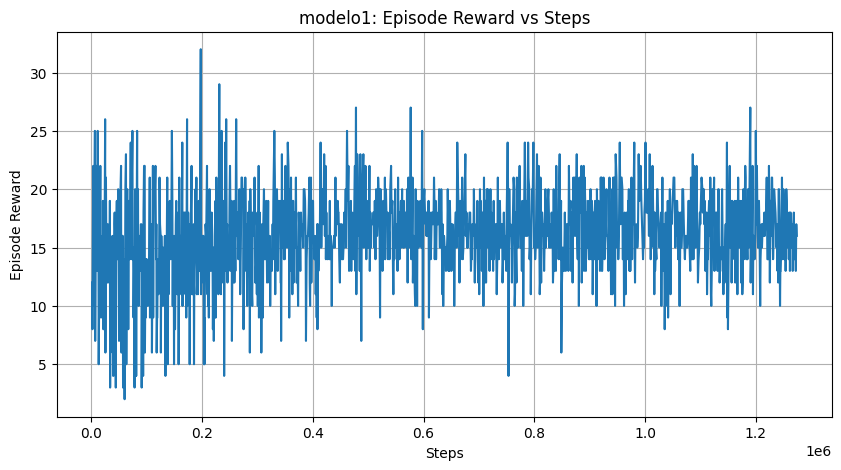

[INFO] Hiperparámetros cargados desde /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo1/modelo1.json
[DQN] Cargando último checkpoint: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo1/checkpoints/dqn_SpaceInvaders-v0_weights_1750000.h5f
Testing for 10 episodes ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: reward: 19.000, steps: 715
Episode 2: reward: 19.000, steps: 710
Episode 3: reward: 18.000, steps: 721
Episode 4: reward: 19.000, steps: 719
Episode 5: reward: 19.000, steps: 719
Episode 6: reward: 19.000, steps: 717
Episode 7: reward: 19.000, steps: 727
Episode 8: reward: 18.000, steps: 708
Episode 9: reward: 19.000, steps: 738
Episode 10: reward: 19.000, steps: 711
Recompensa media sobre 10 episodios: 18.8


In [ ]:
model_name="modelo1"

# CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
# PATH DEL LOGGER
csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')
# DIBUJAR GRÁFICA
graph_training_csv(csv_path, MODEL_DIR, model_name, save_clean_csv=False)
load_hyperparams(model_name)

# MODELO
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1,
                              value_test=.05,
                              nb_steps=SCHEDULER_STEPS)
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=WARMUP_STEPS,
               gamma=GAMMA,
               target_model_update=MODEL_UPDATE,
               train_interval=4,
               delta_clip=DELTA_CLIP)
dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

# Carga de pesos
_, _,latest_checkpoint= load_last_checkpoint(dqn)
dqn.load_weights(latest_checkpoint)
history=dqn.test(env, nb_episodes=10, visualize=False)
episode_rewards = history.history['episode_reward']
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Recompensa media sobre 10 episodios: {average_reward}")

 Utilizando los hiperparámetros por defecto podemos apreciar que al inicio del entrenamiento (menos de 200,000 pasos) hay una alta variabilidad en las recompensas por episodio, con valores que van desde muy bajos hasta unos 30 puntos. Esto es típico, ya que el agente está explorando y aprendiendo. Después de los 200,000 pasos, la recompensa se mantiene relativamente estable en un rango entre 10 y 20 puntos, con picos esporádicos hacia 25. Esto sugiere que el modelo ha aprendido una política relativamente buena, aunque no llega consistentemente a la recompensa máxima. No se esperan mejoras después de los 600,000 pasos.

 Con respecto al test en 10 episodios, apreciamos una gran estabilización entre 18 y 19 puntos de recompensa, sin embargo, no es suficiente para alcanzar el objetivo del proyecto.

### Modelo 1.2

[INFO] Gráfica guardada en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo2/modelo2_episode_reward_fixed_steps.png


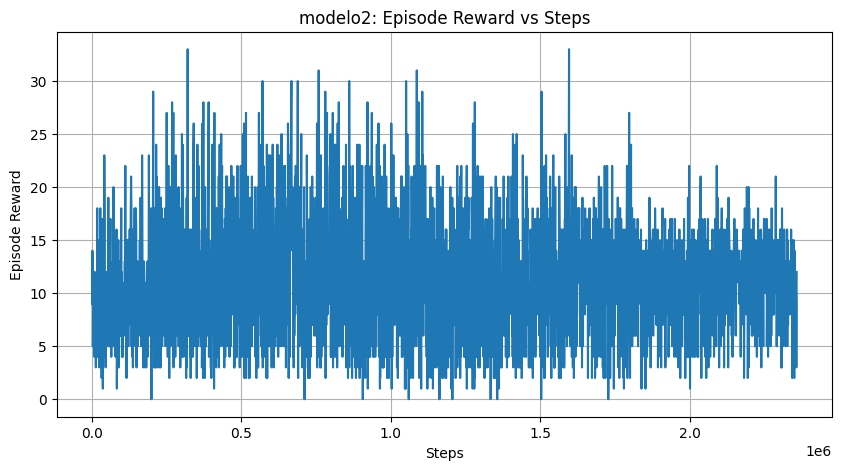

[INFO] Hiperparámetros cargados desde /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo2/modelo2.json
[DQN] Cargando último checkpoint: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo2/checkpoints/dqn_SpaceInvaders-v0_weights_2325000.h5f
Testing for 10 episodes ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: reward: 7.000, steps: 939
Episode 2: reward: 8.000, steps: 947
Episode 3: reward: 5.000, steps: 637
Episode 4: reward: 4.000, steps: 908
Episode 5: reward: 6.000, steps: 903
Episode 6: reward: 5.000, steps: 965
Episode 7: reward: 5.000, steps: 955
Episode 8: reward: 5.000, steps: 933
Episode 9: reward: 5.000, steps: 948
Episode 10: reward: 5.000, steps: 954
Recompensa media sobre 10 episodios: 5.5


In [ ]:
model_name="modelo2"

# CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
# PATH DEL LOGGER
csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')
# DIBUJAR GRÁFICA
graph_training_csv(csv_path, MODEL_DIR, model_name, save_clean_csv=False)
load_hyperparams(model_name)

# MODELO
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1,
                              value_test=.05,
                              nb_steps=SCHEDULER_STEPS)
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=WARMUP_STEPS,
               gamma=GAMMA,
               target_model_update=MODEL_UPDATE,
               train_interval=4,
               delta_clip=DELTA_CLIP)
dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

# Carga de pesos
_, _,latest_checkpoint= load_last_checkpoint(dqn)
dqn.load_weights(latest_checkpoint)
history=dqn.test(env, nb_episodes=10, visualize=False)
episode_rewards = history.history['episode_reward']
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Recompensa media sobre 10 episodios: {average_reward}")

Vicente-> más train steps 3000000 más scheduler steps 2500000-> más tiempo para explorar

### Modelo 1.3

[INFO] Gráfica guardada en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo3/modelo3_episode_reward_fixed_steps.png


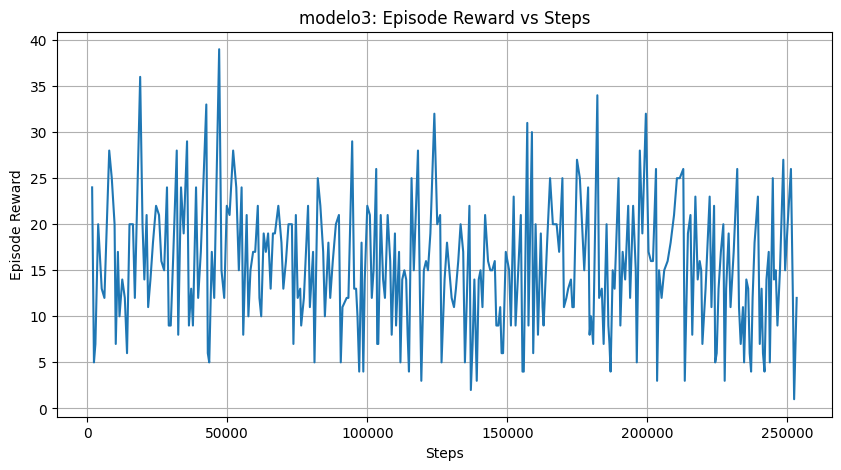

[INFO] Hiperparámetros cargados desde /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo3/modelo3.json
[DQN] Cargando último checkpoint: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo3/checkpoints/dqn_SpaceInvaders-v0_weights_1450000.h5f
Testing for 10 episodes ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: reward: 17.000, steps: 770
Episode 2: reward: 9.000, steps: 616
Episode 3: reward: 15.000, steps: 640
Episode 4: reward: 8.000, steps: 674
Episode 5: reward: 9.000, steps: 538
Episode 6: reward: 10.000, steps: 618
Episode 7: reward: 12.000, steps: 835
Episode 8: reward: 8.000, steps: 397
Episode 9: reward: 10.000, steps: 515
Episode 10: reward: 11.000, steps: 900
Recompensa media sobre 10 episodios: 10.9


In [ ]:
model_name="modelo3"

# CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
# PATH DEL LOGGER
csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')
# DIBUJAR GRÁFICA
graph_training_csv(csv_path, MODEL_DIR, model_name, save_clean_csv=False)
load_hyperparams(model_name)

# MODELO
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1,
                              value_test=.05,
                              nb_steps=SCHEDULER_STEPS)
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=WARMUP_STEPS,
               gamma=GAMMA,
               target_model_update=MODEL_UPDATE,
               train_interval=4,
               delta_clip=DELTA_CLIP)
dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

# Carga de pesos
_, _,latest_checkpoint= load_last_checkpoint(dqn)
dqn.load_weights(latest_checkpoint)
history=dqn.test(env, nb_episodes=10, visualize=False)
episode_rewards = history.history['episode_reward']
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Recompensa media sobre 10 episodios: {average_reward}")

Vicente: bajo lr a 0.0001 con hiperparámetros originales

### Modelo 1.4

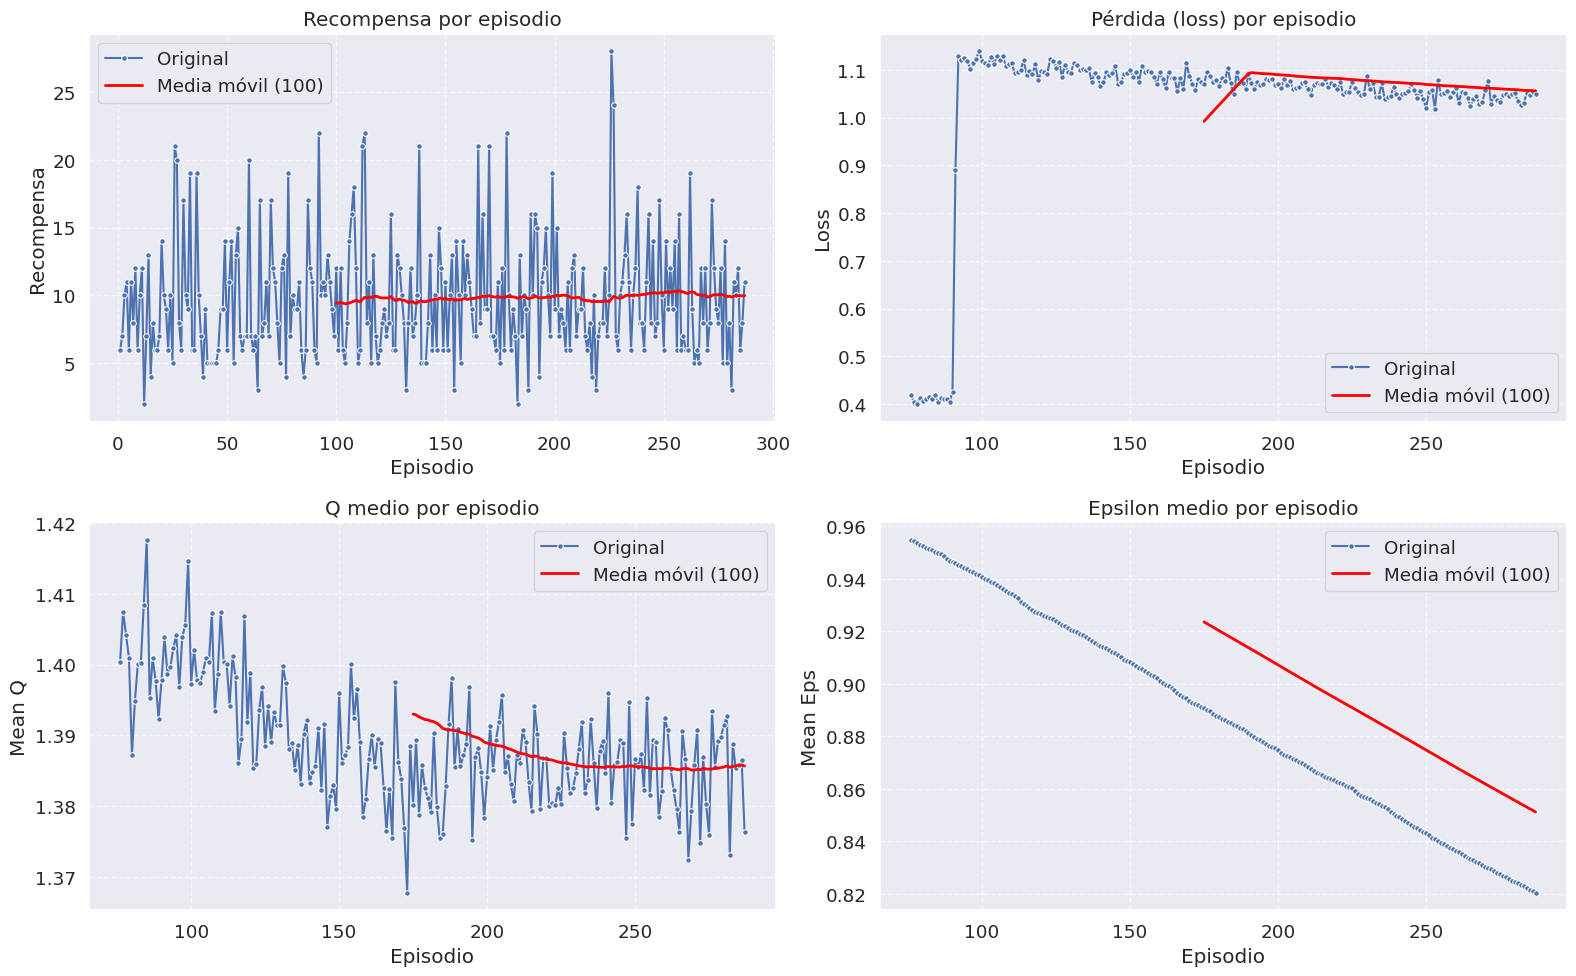

Gráfico guardado en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo4/graphs/20250630193453_modelo4_training_analyze_graph.png
CSV de informe guardado en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo4/graphs/20250630193453_modelo4_training_analyze_log.csv

INFORME DEL TRAINING (Todas las métricas)
----------------------------------------
Episodios totales: 287
Recompensa media: 9.71
Recompensa máxima: 28.0
Recompensa mínima: 2.0
Loss medio: 1.027201
Mean Q medio: 1.388958
Epsilon medio: 0.887332
Pasos medios por episodio: 99266.67
La recompensa final (11.00) es mayor que la inicial (6.00), indicando una mejora.

INFORME DEL TRAINING (últimos 100 episodios completados 187 al 286)
----------------------------------------
Episodios totales: 286
Recompensa media: 9.96
Recompensa máxima: 28.0
Recompensa mínima: 3.0
Loss medio: 1.056162
Mean Q medio: 1.385816
Epsilon medio: 0.851835
Pasos medios por episodio: 164977.02
La recompens

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: reward: 16.000, steps: 1084
Episode 2: reward: 12.000, steps: 747
Episode 3: reward: 12.000, steps: 703
Episode 4: reward: 4.000, steps: 355
Episode 5: reward: 11.000, steps: 689
Episode 6: reward: 10.000, steps: 577
Episode 7: reward: 10.000, steps: 628
Episode 8: reward: 14.000, steps: 822
Episode 9: reward: 12.000, steps: 752
Episode 10: reward: 26.000, steps: 1134
Recompensa media sobre 10 episodios: 12.7


In [ ]:
model_name="modelo4"

# CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
# PATH DEL LOGGER
csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')
# DIBUJAR GRÁFICA
analyze_training(model_name,100)
load_hyperparams(model_name)

# MODELO
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1,
                              value_test=.05,
                              nb_steps=SCHEDULER_STEPS)
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=WARMUP_STEPS,
               gamma=GAMMA,
               target_model_update=MODEL_UPDATE,
               train_interval=4,
               delta_clip=DELTA_CLIP)
dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

# Carga de pesos
_, _,latest_checkpoint= load_last_checkpoint(dqn)
dqn.load_weights(latest_checkpoint)
history=dqn.test(env, nb_episodes=10, visualize=False)
episode_rewards = history.history['episode_reward']
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Recompensa media sobre 10 episodios: {average_reward}")

Vicente: bajo lr a 5e-05: explicar que se mejoró el callback del logegr y la función de visualización

### Modelo 1.5

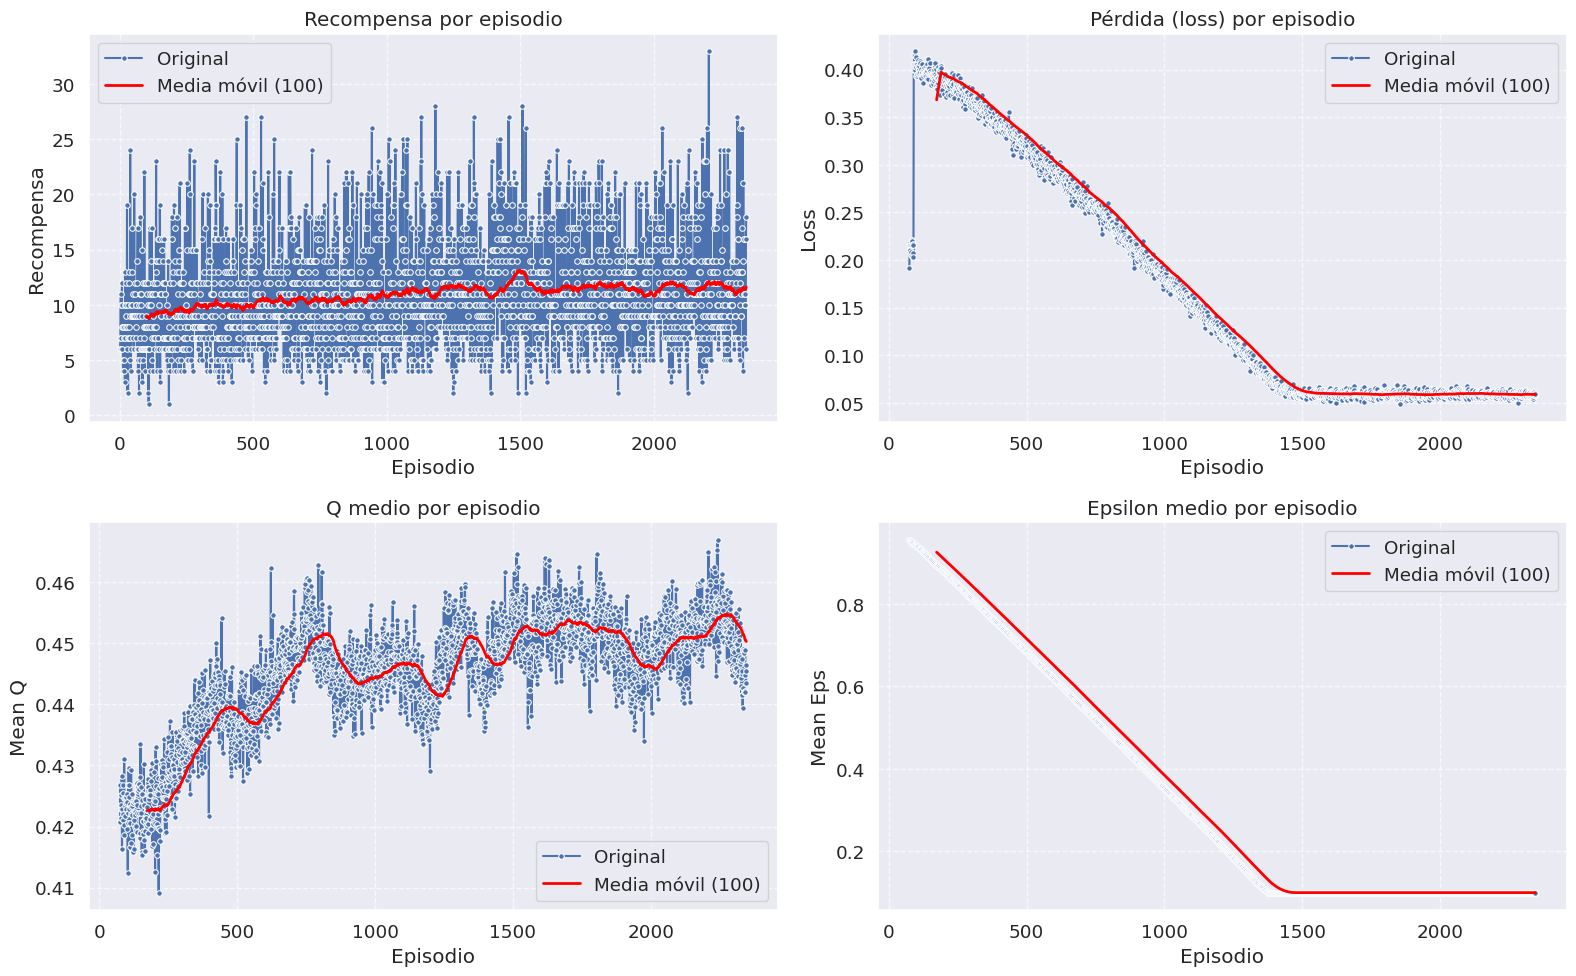

Gráfico guardado en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo5/graphs/20250630193549_modelo5_training_analyze_graph.png
CSV de informe guardado en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo5/graphs/20250630193549_modelo5_training_analyze_log.csv

INFORME DEL TRAINING (Todas las métricas)
----------------------------------------
Episodios totales: 2346
Recompensa media: 10.90
Recompensa máxima: 33.0
Recompensa mínima: 1.0
Loss medio: 0.169788
Mean Q medio: 0.445032
Epsilon medio: 0.347899
Pasos medios por episodio: 859231.77
La recompensa final (18.00) es mayor que la inicial (6.00), indicando una mejora.

INFORME DEL TRAINING (últimos 100 episodios completados 2246 al 2345)
----------------------------------------
Episodios totales: 2345
Recompensa media: 11.51
Recompensa máxima: 27.0
Recompensa mínima: 4.0
Loss medio: 0.058803
Mean Q medio: 0.450409
Epsilon medio: 0.100000
Pasos medios por episodio: 1710607.46
La r

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: reward: 11.000, steps: 650
Episode 2: reward: 13.000, steps: 646
Episode 3: reward: 28.000, steps: 1540
Episode 4: reward: 4.000, steps: 385
Episode 5: reward: 12.000, steps: 713
Episode 6: reward: 11.000, steps: 659
Episode 7: reward: 17.000, steps: 862
Episode 8: reward: 16.000, steps: 1507
Episode 9: reward: 17.000, steps: 1041
Episode 10: reward: 19.000, steps: 1312
Recompensa media sobre 10 episodios: 14.8


In [ ]:
model_name="modelo5"

# CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
# PATH DEL LOGGER
csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')
# DIBUJAR GRÁFICA
analyze_training(model_name,100)
load_hyperparams(model_name)

# MODELO
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1,
                              value_test=.05,
                              nb_steps=SCHEDULER_STEPS)
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=WARMUP_STEPS,
               gamma=GAMMA,
               target_model_update=MODEL_UPDATE,
               train_interval=4,
               delta_clip=DELTA_CLIP)
dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

# Carga de pesos
_, _,latest_checkpoint= load_last_checkpoint(dqn)
dqn.load_weights(latest_checkpoint)
history=dqn.test(env, nb_episodes=10, visualize=False)
episode_rewards = history.history['episode_reward']
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Recompensa media sobre 10 episodios: {average_reward}")

Vicente bajé el memory size a 100000 en vez de 1 millón porque colab me capaba recursos y probé con el lr otra vez de 1 e-5

### Modelo 1.6

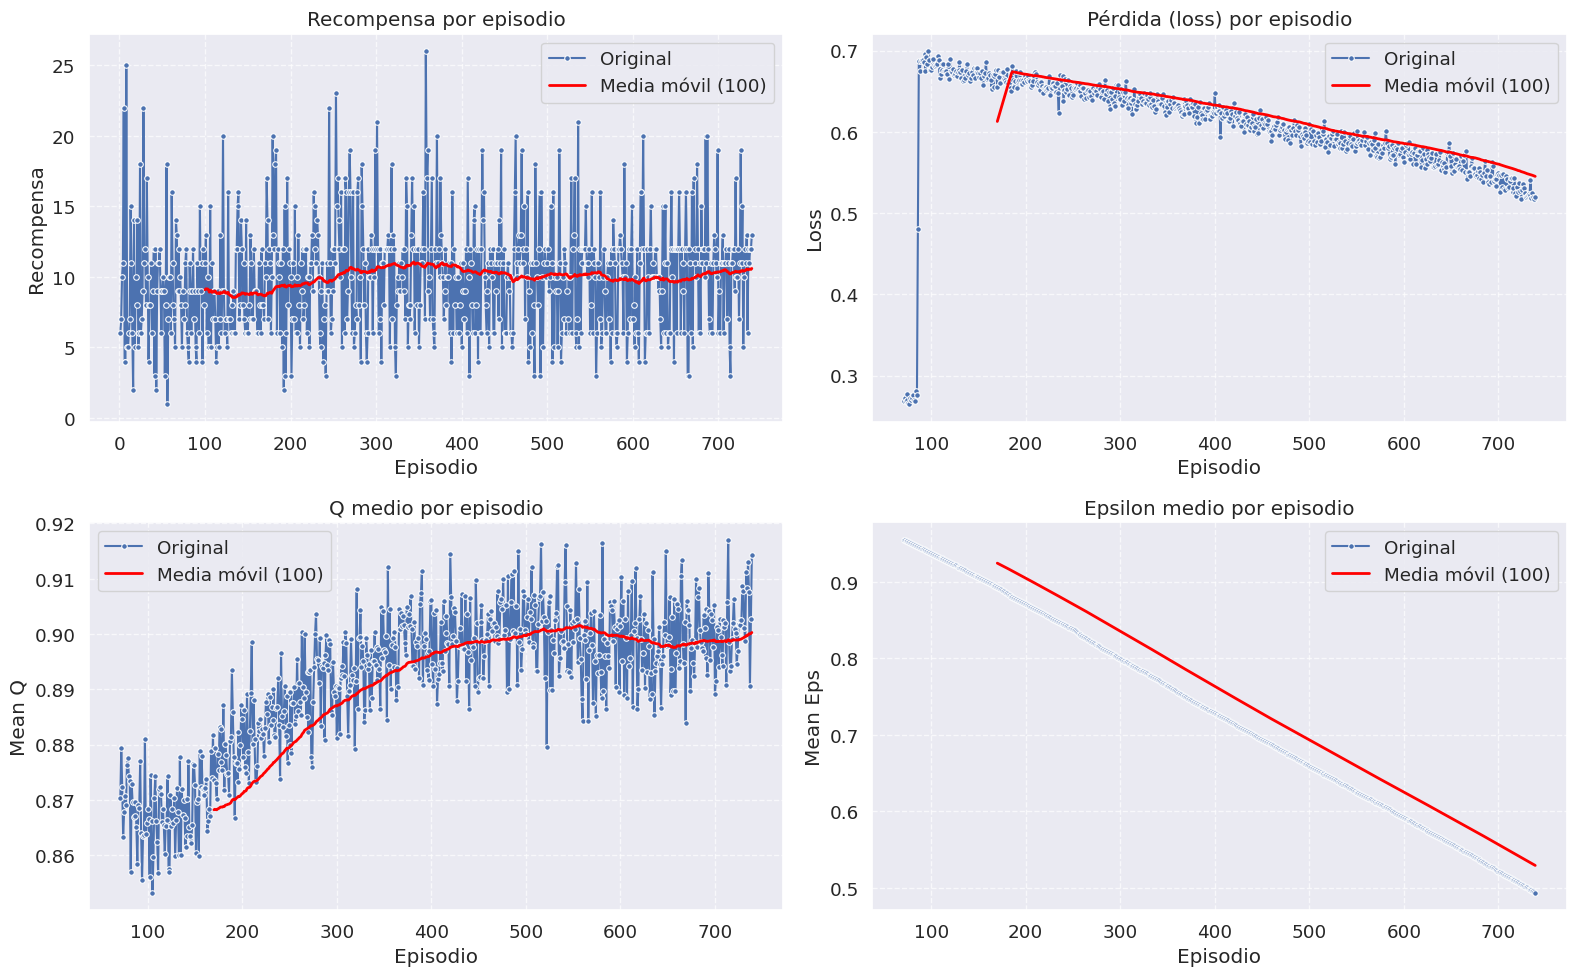

Gráfico guardado en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo6/graphs/20250630193758_modelo6_training_analyze_graph.png
CSV de informe guardado en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo6/graphs/20250630193758_modelo6_training_analyze_log.csv

INFORME DEL TRAINING (Todas las métricas)
----------------------------------------
Episodios totales: 739
Recompensa media: 10.00
Recompensa máxima: 26.0
Recompensa mínima: 1.0
Loss medio: 0.606840
Mean Q medio: 0.891610
Epsilon medio: 0.726569
Pasos medios por episodio: 277767.40
La recompensa final (13.00) es mayor que la inicial (6.00), indicando una mejora.

INFORME DEL TRAINING (últimos 100 episodios completados 639 al 738)
----------------------------------------
Episodios totales: 738
Recompensa media: 10.53
Recompensa máxima: 20.0
Recompensa mínima: 3.0
Loss medio: 0.545493
Mean Q medio: 0.900110
Epsilon medio: 0.529875
Pasos medios por episodio: 522753.60
La recomp

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: reward: 12.000, steps: 852
Episode 2: reward: 11.000, steps: 823
Episode 3: reward: 25.000, steps: 1672
Episode 4: reward: 6.000, steps: 671
Episode 5: reward: 5.000, steps: 413
Episode 6: reward: 11.000, steps: 798
Episode 7: reward: 12.000, steps: 882
Episode 8: reward: 12.000, steps: 854
Episode 9: reward: 12.000, steps: 811
Episode 10: reward: 12.000, steps: 824
Recompensa media sobre 10 episodios: 11.8


In [ ]:
model_name="modelo6"

# CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
# PATH DEL LOGGER
csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')
# DIBUJAR GRÁFICA
analyze_training(model_name,100)
load_hyperparams(model_name)

# MODELO
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1,
                              value_test=.05,
                              nb_steps=SCHEDULER_STEPS)
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=WARMUP_STEPS,
               gamma=GAMMA,
               target_model_update=MODEL_UPDATE,
               train_interval=4,
               delta_clip=DELTA_CLIP)
dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

# Carga de pesos
_, _,latest_checkpoint= load_last_checkpoint(dqn)
dqn.load_weights(latest_checkpoint)
history=dqn.test(env, nb_episodes=10, visualize=False)
episode_rewards = history.history['episode_reward']
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Recompensa media sobre 10 episodios: {average_reward}")

Vicente volví a los hiperparámetros originales y cambié el tain steps a 5 millones y con el scheduler steps a 1 millón todavía

# Modelos D

## Modelo D1

Aquí se presenta una variante del modelo 1 en la que introducimos pequeños cambios en la arquitectura que nos pueden ayudar a conseguir la puntuación mínima, ya que en el modelo 1 nos quedamos muy cerca.

Los cambios consisten en un padding 'same' para prservar mejor las características espaciales en bordes, una leakyReLU para evitar neuronas muertas con un factor alpha de una décima (estandar en juegos), una capa extra de 128 filtros que captura patrones más complejos en el movimiento de los marcianitos, un dropout del 20% para reducir el overfitting y una reducción de las capas densas que es más eficiente y más que suficiente para el juego space invaders.

Se espera que la combinación de la leakyReLU y el dropout mejoren el flujo de gradientes y la generalización y que la tercera capa convolucional detecte patrones más finos en los disparos y los movimientos.


VICENTE: MIRATE TAMBIEN LOS COMENTARIOS EN LOS HIPERPARAMETROS EN LOS ARCHIVOS DE CADA UNO DE MIS MODELOS EN MI CARPETA, APARTE DE LOS QUE YO PONGO EN ESTE TIPO DE CELDAS INTRODUCTORIAS, PORQUE TE VA A AYUDAR A LA DISCUSION ENTRE MODELOS

In [ ]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout



model_name="modelo_D1"
model = Sequential()

input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

#Capa de preprocesamiento
if K.image_data_format() == 'channels_last':
    model.add(Permute((2, 3, 1), input_shape=input_shape))
else:
    model.add(Permute((1, 2, 3), input_shape=input_shape))

model.add(Lambda(lambda x: x / 255.0))

#Bloques convolucionales mejorados:
model.add(Convolution2D(32, (8, 8), strides=(4, 4), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))  # LeakyReLU en lugar de ReLU

model.add(Convolution2D(64, (4, 4), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Convolution2D(128, (3, 3), strides=(1, 1), padding='same'))  # Nueva capa
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

#Capas densas optimizadas:
model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))  # Regularización

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))

#Salida:
model.add(Dense(nb_actions))
model.add(Activation('linear'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 84, 84, 4)         0         
_________________________________________________________________
lambda (Lambda)              (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
batch_normalization (BatchNo (None, 21, 21, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
__________________________________________________

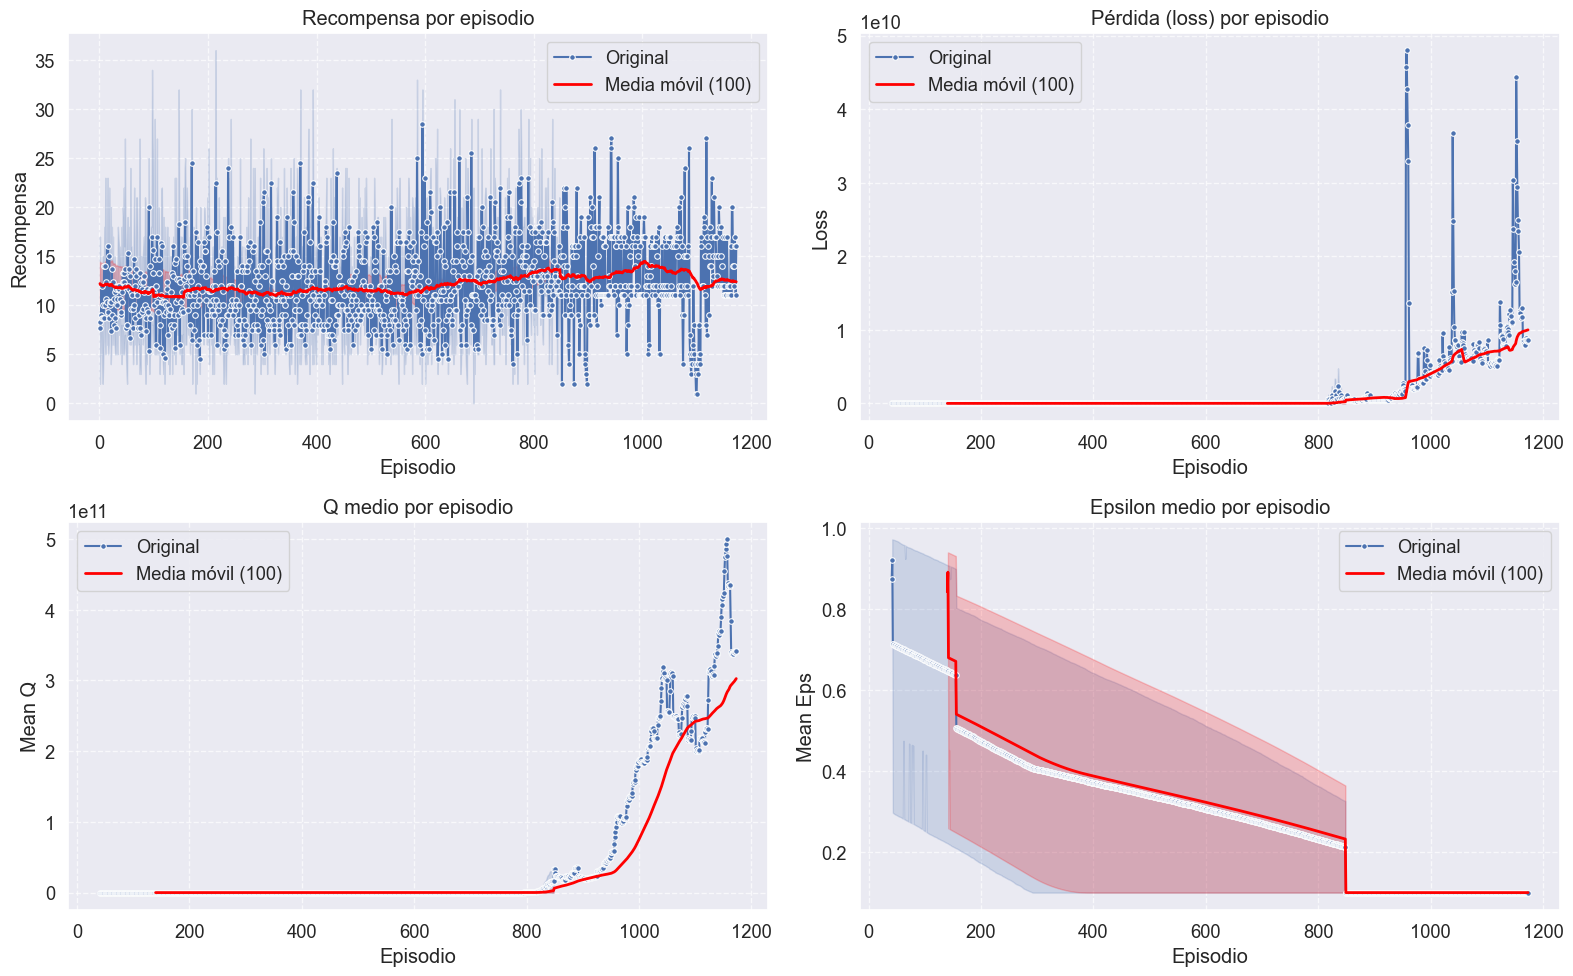

Gráfico guardado en: ./models\modelo_D1\graphs\20250630234428_modelo_D1_training_analyze_graph.png
CSV de informe guardado en: ./models\modelo_D1\graphs\20250630234428_modelo_D1_training_analyze_log.csv

INFORME DEL TRAINING (Todas las métricas)
----------------------------------------
Episodios totales: 1173
Recompensa media: 11.96
Recompensa máxima: 36.0
Recompensa mínima: 0.0
Loss medio: 965831836.181411
Mean Q medio: 27851014004.225334
Epsilon medio: 0.359695
Pasos medios por episodio: 405244.67
La recompensa final (16.00) es mayor que la inicial (6.00), indicando una mejora.

INFORME DEL TRAINING (últimos 100 episodios completados 1073 al 1172)
----------------------------------------
Episodios totales: 1172
Recompensa media: 12.40
Recompensa máxima: 27.0
Recompensa mínima: 1.0
Loss medio: 9971800620.000000
Mean Q medio: 301419978000.000000
Epsilon medio: 0.100000
Pasos medios por episodio: 1005251.90
La recompensa final (11.00) no ha mejorado significativamente respecto a la inic

x:\08_MIAR\actividades\proyecto_practico\venv_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 1: reward: 18.000, steps: 722
Episode 2: reward: 18.000, steps: 724
Episode 3: reward: 18.000, steps: 717
Episode 4: reward: 18.000, steps: 717
Episode 5: reward: 18.000, steps: 709
Episode 6: reward: 18.000, steps: 720
Episode 7: reward: 18.000, steps: 711
Episode 8: reward: 18.000, steps: 722
Episode 9: reward: 18.000, steps: 729
Episode 10: reward: 18.000, steps: 718
Recompensa media sobre 10 episodios: 18.0


In [ ]:
model_name="modelo_D1"

# CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
# PATH DEL LOGGER
csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')
# DIBUJAR GRÁFICA
analyze_training(model_name,100)
load_hyperparams(model_name)

# MODELO
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1,
                              value_test=.05,
                              nb_steps=SCHEDULER_STEPS)
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=WARMUP_STEPS,
               gamma=GAMMA,
               target_model_update=MODEL_UPDATE,
               train_interval=4,
               delta_clip=DELTA_CLIP)
dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

# Carga de pesos
_, _,latest_checkpoint= load_last_checkpoint(dqn)
dqn.load_weights(latest_checkpoint)
history=dqn.test(env, nb_episodes=10, visualize=False)
episode_rewards = history.history['episode_reward']
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Recompensa media sobre 10 episodios: {average_reward}")

## Modelo D1+

Aquí se presenta una variante del modelo D1

Gaussian Noise en input:

Mejora generalización simulando variaciones en pixels

SpatialDropout2D:

Mejor que Dropout para capas convolucionales (elimina canales completos)

Mecanismo de Attention simple:

Ayuda al modelo a enfocarse en enemigos y proyectiles

Inicialización He Normal:

Optimizada para LeakyReLU (mejor flujo de gradientes)

Hiperparámetros ajustados:

GAMMA=0.96: Prioriza disparar enemigos (recompensa inmediata) sin descuidar supervivencia

MODEL_UPDATE=3000: Más estabilidad en aprendizaje profundo

In [ ]:
from tensorflow.keras.layers import LeakyReLU, GaussianNoise, SpatialDropout2D
from tensorflow.keras.layers import Dropout, Conv2D, Multiply



model = Sequential()

input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

#Preprocesamiento
if K.image_data_format() == 'channels_last':
    model.add(Permute((2, 3, 1), input_shape=input_shape))
else:
    model.add(Permute((1, 2, 3), input_shape=input_shape))

model.add(Lambda(lambda x: x / 255.0))
model.add(GaussianNoise(0.01))  #Regularización en input

#Bloques convolucionales
model.add(Conv2D(64, (8, 8), strides=(4, 4), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(SpatialDropout2D(0.1))

model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(SpatialDropout2D(0.1))

#Capas densas
model.add(Flatten())
model.add(Dense(512, kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.1))

#Salida
model.add(Dense(nb_actions, kernel_initializer='glorot_uniform'))
model.add(Activation('linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 84, 84, 4)         0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        16448     
_________________________________________________________________
batch_normalization_3 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 21, 21, 64)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 21, 21, 64)       

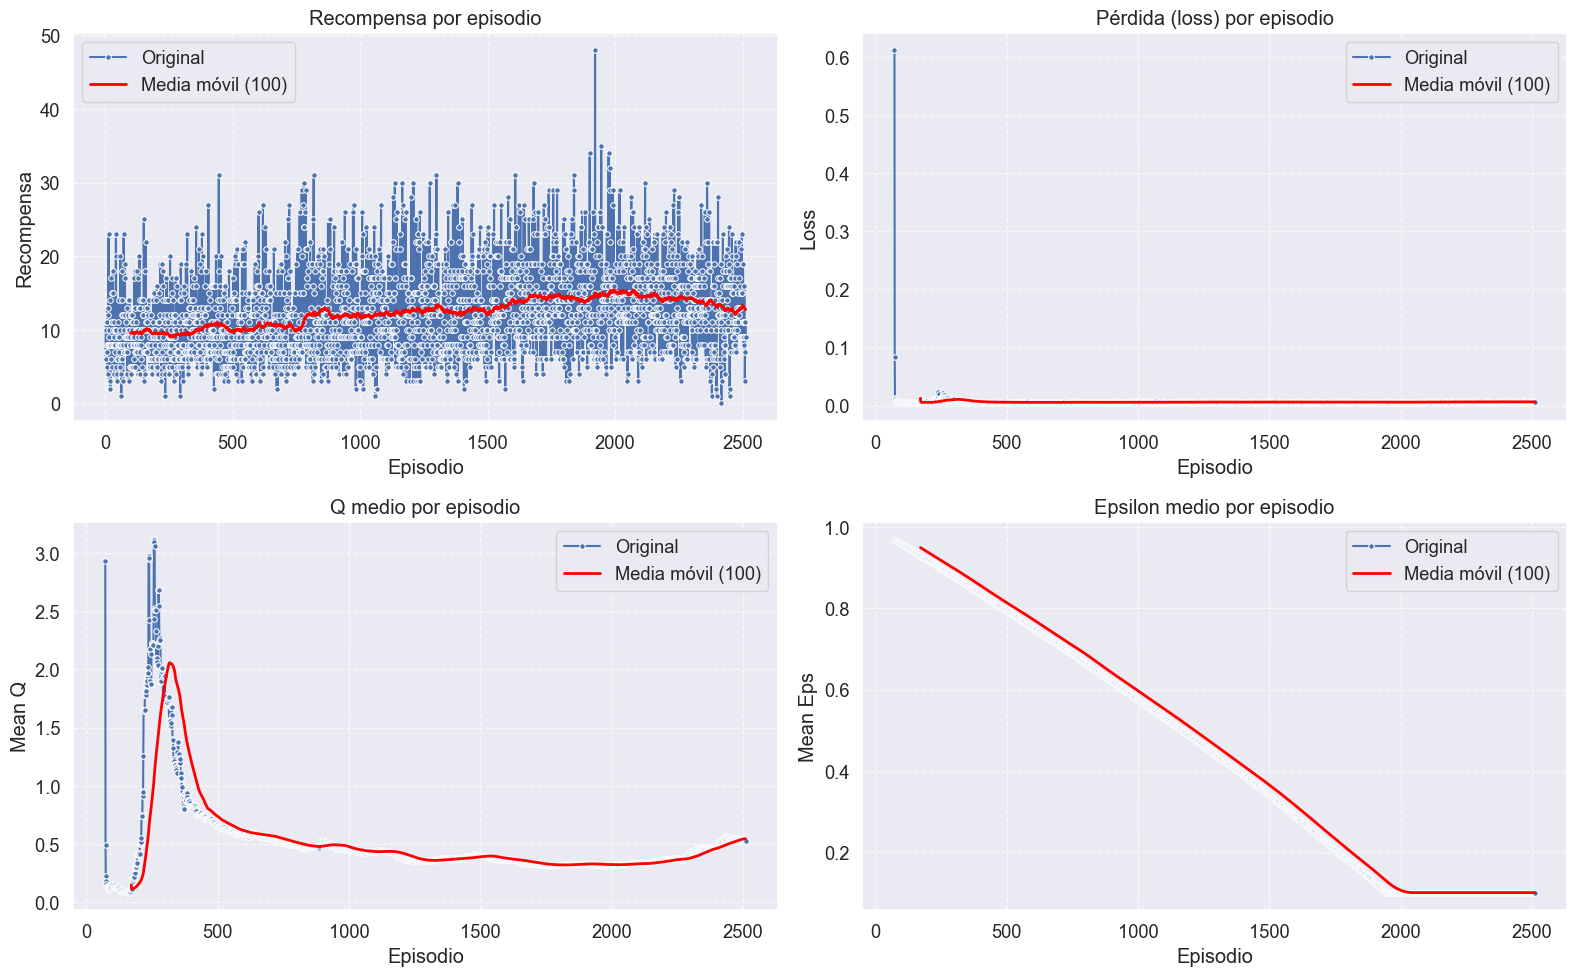

Gráfico guardado en: ./models\modelo_D1_Plus\graphs\20250630234515_modelo_D1_Plus_training_analyze_graph.png
CSV de informe guardado en: ./models\modelo_D1_Plus\graphs\20250630234515_modelo_D1_Plus_training_analyze_log.csv

INFORME DEL TRAINING (Todas las métricas)
----------------------------------------
Episodios totales: 2511
Recompensa media: 12.37
Recompensa máxima: 48.0
Recompensa mínima: 0.0
Loss medio: 0.006508
Mean Q medio: 0.513568
Epsilon medio: 0.453380
Pasos medios por episodio: 942764.10
La recompensa final (9.00) es mayor que la inicial (6.00), indicando una mejora.

INFORME DEL TRAINING (últimos 100 episodios completados 2411 al 2510)
----------------------------------------
Episodios totales: 2510
Recompensa media: 12.74
Recompensa máxima: 24.0
Recompensa mínima: 0.0
Loss medio: 0.006403
Mean Q medio: 0.545013
Epsilon medio: 0.100000
Pasos medios por episodio: 1954720.45
La recompensa final (11.00) es mayor que la inicial (6.00), indicando una mejora.
[INFO] Hiperparám

x:\08_MIAR\actividades\proyecto_practico\venv_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 1: reward: 6.000, steps: 711
Episode 2: reward: 3.000, steps: 378
Episode 3: reward: 13.000, steps: 954
Episode 4: reward: 3.000, steps: 601
Episode 5: reward: 7.000, steps: 687
Episode 6: reward: 16.000, steps: 1758
Episode 7: reward: 9.000, steps: 989
Episode 8: reward: 3.000, steps: 381
Episode 9: reward: 9.000, steps: 917
Episode 10: reward: 13.000, steps: 1064
Recompensa media sobre 10 episodios: 8.2


In [ ]:
model_name = "modelo_D1_Plus"

# CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
# PATH DEL LOGGER
csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')
# DIBUJAR GRÁFICA
analyze_training(model_name,100)
load_hyperparams(model_name)

# MODELO
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1,
                              value_test=.05,
                              nb_steps=SCHEDULER_STEPS)
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=WARMUP_STEPS,
               gamma=GAMMA,
               target_model_update=MODEL_UPDATE,
               train_interval=4,
               delta_clip=DELTA_CLIP)
dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

# Carga de pesos
_, _,latest_checkpoint= load_last_checkpoint(dqn)
dqn.load_weights(latest_checkpoint)
history=dqn.test(env, nb_episodes=10, visualize=False)
episode_rewards = history.history['episode_reward']
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Recompensa media sobre 10 episodios: {average_reward}")

## Modelo D1 Attention +

Aquí se presenta una variante del modelo D1 CON ATENCION

Gaussian Noise en input:

Mejora generalización simulando variaciones en pixels

SpatialDropout2D:

Mejor que Dropout para capas convolucionales (elimina canales completos)

Mecanismo de Attention simple:

Ayuda al modelo a enfocarse en enemigos y proyectiles

Inicialización He Normal:

Optimizada para LeakyReLU (mejor flujo de gradientes)

Hiperparámetros ajustados:

GAMMA=0.96: Prioriza disparar enemigos (recompensa inmediata) sin descuidar supervivencia

MODEL_UPDATE=3000: Más estabilidad en aprendizaje profundo

VICENTE IGNORA DENTRO DE MODELS EL MODELO DE ATTENTION, SOLO FIJATE EN EL DE ENHANCED HYPERPARAMETERS, ES QUE SOBREESCRIBI EL DE ATENCION CON ESTE, QUE DABA BIEN Y EL OTRO ERA UN DESASTRE

In [ ]:
from tensorflow.keras.layers import LeakyReLU, GaussianNoise, SpatialDropout2D
from tensorflow.keras.layers import Dropout, Conv2D, Multiply
from tensorflow.keras.initializers import he_normal, glorot_uniform


# 1. Definición del modelo con Attention
model_name = "modelo_D1_Attention_enhancedhyperparams"
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

# Capa de entrada
inputs = Input(shape=input_shape)

# Preprocesamiento
x = Permute((2, 3, 1))(inputs) if K.image_data_format() == 'channels_last' else Permute((1, 2, 3))(inputs)
x = Lambda(lambda x: x / 255.0)(x)
x = GaussianNoise(0.01)(x)

# Bloques convolucionales
x = Conv2D(64, (8, 8), strides=(4, 4), padding='same', kernel_initializer=he_normal())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = SpatialDropout2D(0.1)(x)

x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=he_normal())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=he_normal())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = SpatialDropout2D(0.1)(x)

# Mecanismo de atención
attention = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Mapa de atención (0 a 1)
x = Multiply()([x, attention])  # Aplicar atención

# Capas densas
x = Flatten()(x)
x = Dense(512, kernel_initializer=he_normal())(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)

x = Dense(256, kernel_initializer=he_normal())(x)
x = LeakyReLU(alpha=0.1)(x)

# Salida
outputs = Dense(nb_actions, kernel_initializer=glorot_uniform(), activation='linear')(x)

# Crear modelo
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 84, 84)]  0                                            
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 84, 84, 4)    0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 84, 84, 4)    0           permute_2[0][0]                  
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 84, 84, 4)    0           lambda_2[0][0]                   
____________________________________________________________________________________________

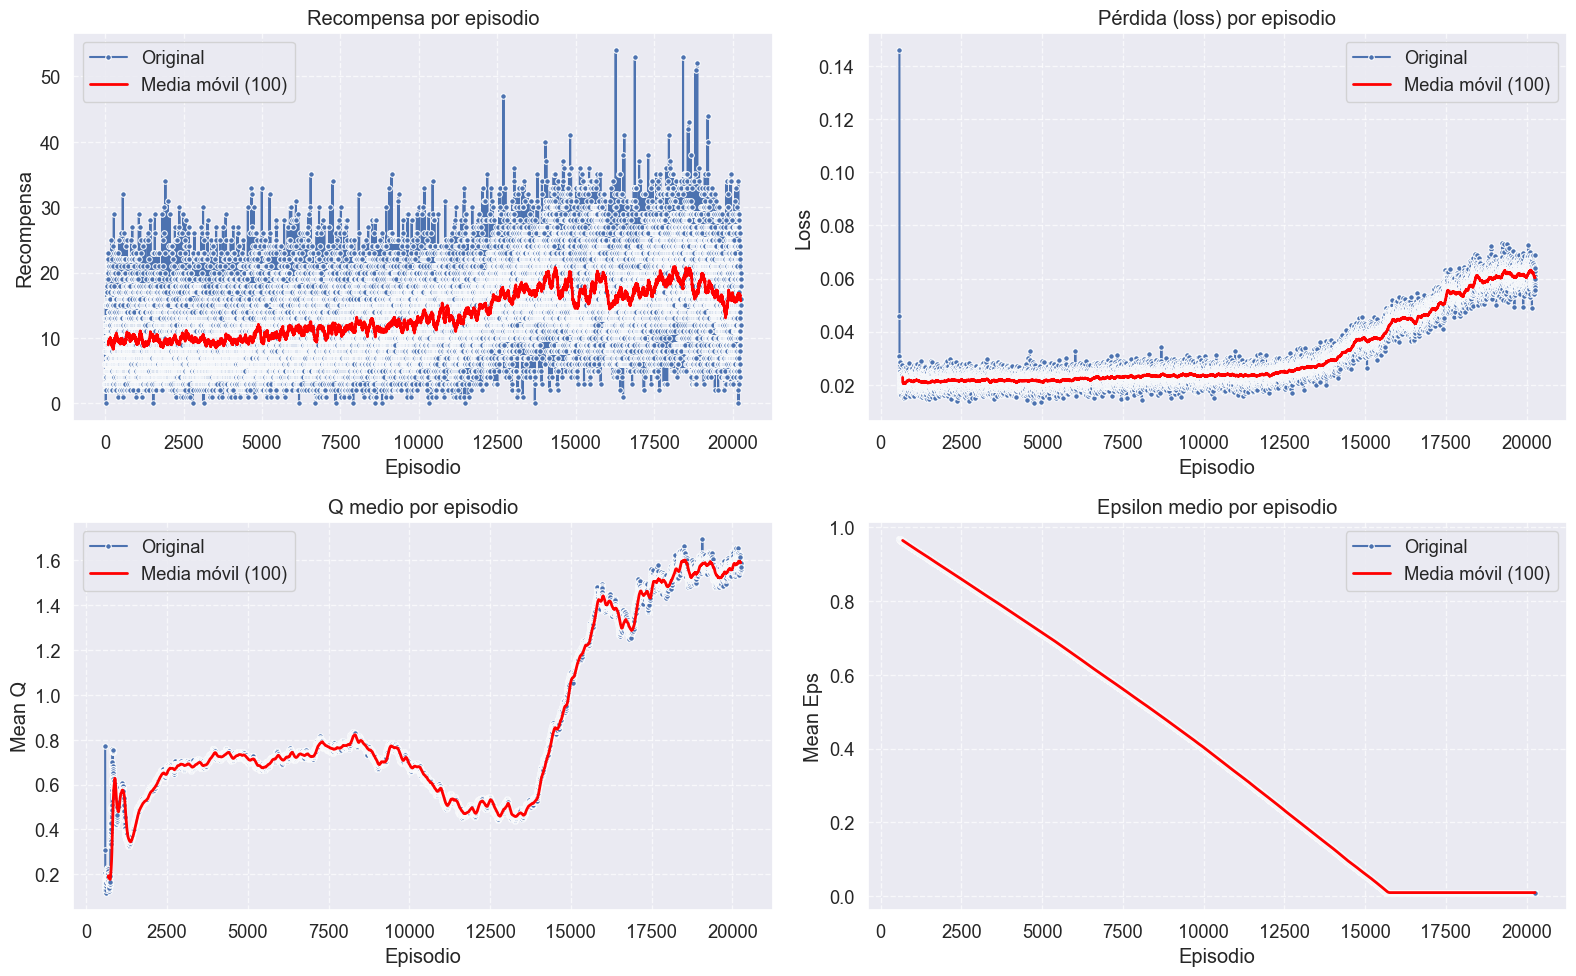

Gráfico guardado en: ./models\modelo_D1_Attention_enhancedhyperparams\graphs\20250630234638_modelo_D1_Attention_enhancedhyperparams_training_analyze_graph.png
CSV de informe guardado en: ./models\modelo_D1_Attention_enhancedhyperparams\graphs\20250630234638_modelo_D1_Attention_enhancedhyperparams_training_analyze_log.csv

INFORME DEL TRAINING (Todas las métricas)
----------------------------------------
Episodios totales: 20260
Recompensa media: 13.57
Recompensa máxima: 54.0
Recompensa mínima: 0.0
Loss medio: 0.031297
Mean Q medio: 0.864301
Epsilon medio: 0.391955
Pasos medios por episodio: 1904686.12
La recompensa final (15.00) es mayor que la inicial (6.00), indicando una mejora.

INFORME DEL TRAINING (últimos 100 episodios completados 20160 al 20259)
----------------------------------------
Episodios totales: 20259
Recompensa media: 15.74
Recompensa máxima: 34.0
Recompensa mínima: 0.0
Loss medio: 0.060484
Mean Q medio: 1.590418
Epsilon medio: 0.010000
Pasos medios por episodio: 3989

x:\08_MIAR\actividades\proyecto_practico\venv_rl\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


[DQN] Cargando último checkpoint: ./models\modelo_D1_Attention_enhancedhyperparams\checkpoints\dqn_SpaceInvaders-v0_weights_2760000.h5f
Testing for 10 episodes ...


x:\08_MIAR\actividades\proyecto_practico\venv_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 1: reward: 31.000, steps: 1039
Episode 2: reward: 24.000, steps: 871
Episode 3: reward: 24.000, steps: 852
Episode 4: reward: 23.000, steps: 940
Episode 5: reward: 30.000, steps: 1065
Episode 6: reward: 28.000, steps: 1062
Episode 7: reward: 26.000, steps: 1053
Episode 8: reward: 23.000, steps: 774
Episode 9: reward: 27.000, steps: 922
Episode 10: reward: 23.000, steps: 838
Recompensa media sobre 10 episodios: 25.9


In [ ]:
model_name = "modelo_D1_Attention_enhancedhyperparams"

# CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
# PATH DEL LOGGER
csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')
# DIBUJAR GRÁFICA
analyze_training(model_name,100)
load_hyperparams(model_name)

# MODELO
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1,
                              value_test=.05,
                              nb_steps=SCHEDULER_STEPS)
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=WARMUP_STEPS,
               gamma=GAMMA,
               target_model_update=MODEL_UPDATE,
               train_interval=4,
               delta_clip=DELTA_CLIP)
dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

# Carga de pesos
_, _,latest_checkpoint= load_last_checkpoint(dqn)
dqn.load_weights(latest_checkpoint)
history=dqn.test(env, nb_episodes=10, visualize=False)
episode_rewards = history.history['episode_reward']
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Recompensa media sobre 10 episodios: {average_reward}")

# MODELO 2

### Red neuronal basada en el paper: [https://arxiv.org/abs/1511.06581](https://arxiv.org/abs/1511.06581)

**Dueling Network Architectures for Deep Reinforcement Learning**
**Autores:** Ziyu Wang, Tom Schaul, Matteo Hessel, Hado van Hasselt, Marc Lanctot, Nando de Freitas.
**Año de publicación:** 2015

El término "Duel DQN" o "Dueling DQN" (DQN con redes en duelo) se refiere a una arquitectura específica de la red neuronal dentro del marco de DQN (o Double DQN, como estamos discutiendo). No son "redes separadas" en el sentido de la red online y la red target, sino una **modificación a la capa de salida de una única red Q** que luego se duplica para formar la red online y la red target.

La idea principal de Dueling DQN es que la función Q se puede descomponer en dos componentes:

1.  **Valor del estado (V(s))**: Cuánto de bueno es estar en un estado dado, independientemente de la acción.
2.  **Ventaja de la acción (A(s, a))**: Cuánto mejor (o peor) es tomar una acción específica en ese estado en comparación con el promedio de las acciones.

Así, la función Q se estima como:

$Q(s, a; \theta, \alpha, \beta) = V(s; \theta, \beta) + (A(s, a; \theta, \alpha) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a'; \theta, \alpha))$

Donde:
* $\theta$: Parámetros de las capas convolucionales (comunes a ambos flujos).
* $\alpha$: Parámetros de la capa densa de ventaja.
* $\beta$: Parámetros de la capa densa de valor.
* $|\mathcal{A}|$: Número de acciones.

Esto permite que la red aprenda la importancia de los estados por separado de la importancia de cada acción.

El paper original donde se introdujo la arquitectura Dueling Network (la base de Dueling DQN) es:

**Título:** **Dueling Network Architectures for Deep Reinforcement Learning**
**Autores:** Ziyu Wang, Tom Schaul, Matteo Hessel, Hado van Hasselt, Marc Lanctot, Nando de Freitas.
**Año de publicación:** 2015
**Enlace (arXiv):** [https://arxiv.org/abs/1511.06581](https://arxiv.org/abs/1511.06581)

Este es el documento fundamental que describe la idea de descomponer la función de valor Q en un valor de estado ($V(s)$) y una función de ventaja de acción ($A(s,a)$), y cómo combinarlos en una única arquitectura de red neuronal. Es un paper de Google DeepMind y ha sido muy influyente en el campo del Aprendizaje por Refuerzo Profundo.

Te recomiendo leerlo para entender a fondo la intuición detrás de la arquitectura y sus beneficios.

Describir la NN

#### Con las siguientes modificaciones:

Modificaciones...

## DQN
DQN implementado basándose en ...

1. Implementación de la red neuronal

In [ ]:
model_name = "modelo2"

# --- 2. Construcción del Modelo Dueling DQN con API Funcional ---

# Define la forma de entrada para el modelo
input_layer_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

# Definimos la capa de entrada del modelo
inputs = Input(shape=input_layer_shape, name='Input_Frames')

# Reorganizar las imágenes para que el window length quede en la dimensión de los canales
if K.image_data_format() == 'channels_last':
    x = Permute((2, 3, 1), name='Permute_Channels')(inputs)
elif K.image_data_format() == 'channels_first':
    # Si ya es (BATCH, CHANNELS, H, W), no necesitamos permutar si INPUT_SHAPE ya incluye el canal.
    # Pero si INPUT_SHAPE es solo (H,W) y WINDOW_LENGTH es el canal, Permute es correcto.
    # Si la entrada es (WINDOW_LENGTH, H, W) y queremos (WINDOW_LENGTH, H, W), esta línea es redundante
    # o puede causar problemas si Keras espera (CHANNELS, H, W)
    # Sin embargo, para consistencia con tu original:
    x = Permute((1, 2, 3), name='Permute_Channels')(inputs) # Asumiendo que WINDOW_LENGTH es el primer "canal"
else:
    raise RuntimeError('Unknown image_data_format.')

# Normalizar los valores de píxeles
x = Lambda(lambda x: x / 255.0, name='Normalize_Pixels')(x)

# Capas convolucionales
# Conv1
x = Convolution2D(32, (8, 8), strides=(4, 4), name='Conv1')(x)
x = BatchNormalization(name='BN1')(x)
x = Activation('relu', name='ReLU1')(x)

# Conv2
x = Convolution2D(64, (4, 4), strides=(2, 2), name='Conv2')(x)
x = BatchNormalization(name='BN2')(x)
x = Activation('relu', name='ReLU2')(x)

# Conv3
x = Convolution2D(64, (3, 3), strides=(1, 1), name='Conv3')(x)
x = BatchNormalization(name='BN3')(x)
x = Activation('relu', name='ReLU3')(x)

# Aplanar la salida de las capas convolucionales antes de las capas densas
flattened_output = Flatten(name='Flatten_Layer')(x)

# --- Ramificación Dueling DQN ---

# 1. Stream para la estimación del Valor (V(s))
# Una capa densa seguida de una salida de un solo valor para el estado
value_stream = Dense(512, name='Value_Dense')(flattened_output)
value_stream = Activation('relu', name='Value_ReLU')(value_stream)
value = Dense(1, activation='linear', name='Value_Output')(value_stream) # Salida de valor escalar

# 2. Stream para la estimación de la Ventaja (A(s,a))
# Una capa densa seguida de salidas para cada acción
advantage_stream = Dense(512, name='Advantage_Dense')(flattened_output)
advantage_stream = Activation('relu', name='Advantage_ReLU')(advantage_stream)
advantage = Dense(nb_actions, activation='linear', name='Advantage_Output')(advantage_stream) # Salida de ventaja para cada acción

# Combinación de Valor y Ventaja para obtener Q(s,a)
# Q(s,a) = V(s) + (A(s,a) - mean(A(s,a')))
# Utilizamos una capa Lambda para esta operación.
# K.mean(a[1], axis=1, keepdims=True) calcula el promedio de las ventajas para todas las acciones
# `keepdims=True` asegura que la forma se mantenga compatible para la resta
output_q_values = Lambda(lambda a: a[0] + (a[1] - K.mean(a[1], axis=1, keepdims=True)),
                         output_shape=(nb_actions,), name='Q_Value_Combined')([value, advantage])

# Crea el modelo final con las entradas y salidas definidas
model = Model(inputs=inputs, outputs=output_q_values, name=model_name)

# Muestra un resumen de la arquitectura de la red
print(f"\nResumen de la Red Dueling DQN: {model_name}")
model.summary()


Resumen de la Red Dueling DQN: modelo2
Model: "modelo2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Frames (InputLayer)      [(None, 4, 84, 84)]  0           []                               
                                                                                                  
 Permute_Channels (Permute)     (None, 84, 84, 4)    0           ['Input_Frames[0][0]']           
                                                                                                  
 Normalize_Pixels (Lambda)      (None, 84, 84, 4)    0           ['Permute_Channels[0][0]']       
                                                                                                  
 Conv1 (Conv2D)                 (None, 20, 20, 32)   8224        ['Normalize_Pixels[0][0]']       
                                                    

2. Implementación de la solución DQN

In [ ]:
# GENERACIÓN O CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
load_hyperparams(model_name)

# Añado los hiperparametros para el modelo dueling
hiperparametros = {
    "MEMORY_SIZE": 40000,             # Mucha más memoria para diversidad
    "WARMUP_STEPS": 10000,             # Más pasos iniciales aleatorios para llenar bien la memoria
    "SCHEDULER_STEPS": 250000,         # Decaimiento más lento para epsilon
    "GAMMA": 0.99,                      # Valorar más el largo plazo (mejor para Atari)
    "MODEL_UPDATE": 5000,               # Target network se actualiza más frecuentemente
    "LEARNING_RATE": 0.00001,           # Más estable (valor típico en Atari DQN)
    "MODEL_CHECKPOINT_STEPS": 20000,    # Guardar modelo con menos frecuencia
    "TRAIN_STEPS": 3000000,             # Aumenta los pasos totales de entrenamiento
    "TRAIN_INTERVAL": 3,                # Entrena cada 4 pasos de entorno
    "LOG_INTERVAL": 10000,              # Intervalo logs
    "DELTA_CLIP": 1.0,                  # Clip de gradiente más amplio (0.5 podría ser muy restrictivo)
    "ENABLE_DOUBLE_DQN": True,          # Mantener Double DQN
    "ENABLE_DUELING_NETWORK": True,     # Mantener Dueling
    "EPSILON_START": 1.0,               # Máxima exploracion al inicio
    "EPSILON_MIN": 0.1,                 # Que continúe explorando
    "BATCH_SIZE": 64                    # Batch mayor para gradientes más estables
}

# Guardar cambios
save_hyperparams(model_name)

# Volver a cargar para crear las variables globales nuevas
load_hyperparams(model_name)


[INFO] Hiperparámetros cargados desde /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo2/modelo2.json
[INFO] Hiperparámetros guardados en /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo2/modelo2.json
[INFO] Hiperparámetros cargados desde /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo2/modelo2.json


In [ ]:
# DEFINICIÓN DE LA POLICY
memory, last_checkpoint_steps=get_memory_and_last_steps()

value_max, value_min, new_scheduler_steps = adjust_policy_params(
    scheduler_steps=SCHEDULER_STEPS,
    train_steps=TRAIN_STEPS,
    current_step=last_checkpoint_steps
)
if not memory:
  memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
  print("Memoria inicializada de 0")

print(f"Valores de la policy: value_min={value_min}, value_max={value_max}, scheduler_steps={new_scheduler_steps}")

processor = AtariProcessor()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=EPSILON_START,
                              value_min=EPSILON_MIN,
                              value_test=.05,
                              nb_steps=new_scheduler_steps)


In [ ]:
dqn = DQNAgent(model=model,
                     nb_actions=nb_actions,
                     policy=policy,
                     memory=memory,
                     processor=processor,
                     nb_steps_warmup=WARMUP_STEPS,
                     gamma=GAMMA,
                     target_model_update=MODEL_UPDATE,
                     batch_size=BATCH_SIZE,
                     train_interval=4,
                     delta_clip=DELTA_CLIP,
                     enable_double_dqn=ENABLE_DOUBLE_DQN,
                     enable_dueling_network=ENABLE_DUELING_NETWORK)

if IN_COLAB:
    # Parche para evitar el error 'get_updates' que ya no existe
    def patched_get_updates(self, loss, params):
        return []
    Adam.get_updates = patched_get_updates

# Compilo con el agente el modelo
dqn.compile(
    Adam(learning_rate=hiperparametros["LEARNING_RATE"]),
    metrics=['mae']
)

In [ ]:
weights_filename = os.path.join(WEIGHTS_DIR, 'dqn_{}_weights_{}.h5f'.format(env_name, model_name))
checkpoint_weights_filename = os.path.join(CHECKPOINTS_DIR, 'dqn_' + env_name + '_weights_{step}.h5f')
log_filename =os.path.join(MODEL_DIR, 'dqn_{}_log_{}.json'.format(env_name, model_name))
log_csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')

In [ ]:
# CARGAR PESOS DEL ÚLTIMO CHECKPOINT SI EXISTE
dqn, last_checkpoint_steps = load_last_checkpoint(dqn)
# CREAR CALLBACKS CUSTOMIZADOS QUE GUARDAN BIEN LOS CHECKPOINTS Y LOGS DEL TRAINING
checkpoint_callback = AccumulatedCheckpoint(
      base_path=CHECKPOINTS_DIR,
      env_name=env_name,
      interval=MODEL_CHECKPOINT_STEPS,
      initial_step=last_checkpoint_steps
  )
callbacks = [checkpoint_callback]
dqn.step = last_checkpoint_steps
callbacks += [EpisodeLoggerCSV(log_csv_path)]

[DQN] Cargando último checkpoint: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo2/checkpoints/dqn_SpaceInvaders-v0_weights_50000.h5f
Callback iniciado desde paso 50000
Steps que llevaba el modelo entrenado: 50000


In [ ]:
# ENTRENAR EL DQN
print(json.dumps(hiperparametros, indent=4))

if TRAIN_STEPS>0:
  dqn.fit(env, callbacks=callbacks, nb_steps=TRAIN_STEPS-last_checkpoint_steps, log_interval=LOG_INTERVAL, visualize=False)
  dqn.save_weights(weights_filename, overwrite=True)

Training for 1700000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 71s 7ms/step - reward: 0.0141
14 episodes - episode_reward: 9.500 [6.000, 15.000] - ale.lives: 2.090

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 70s 7ms/step - reward: 0.0130
15 episodes - episode_reward: 8.600 [4.000, 17.000] - ale.lives: 2.098

Interval 3 (20000 steps performed)
 4999/10000 [=============>................] - ETA: 27s - reward: 0.0120
[Checkpoint] Guardado en paso 75000: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/modelo2/checkpoints/dqn_SpaceInvaders-v0_weights_75000.h5f
10000/10000 [==============================] - 56s 6ms/step - reward: 0.0138
14 episodes - episode_reward: 10.000 [5.000, 16.000] - ale.lives: 2.037

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 59s 6ms/step - reward: 0.0142
14 episodes - episode_reward: 10.643 [3.000, 27.000] - ale.lives: 2.1

## Nueva versión DDDQN con mas experiencia y exploracion

In [ ]:
model_name = "ddqn.v3.1"

In [ ]:
# GENERACIÓN O CARGA MODELO
MODEL_DIR, WEIGHTS_DIR, CHECKPOINTS_DIR = get_dirs(model_name)
load_hyperparams(model_name)

# Añado los hiperparametros para el modelo dueling
hiperparametros["MEMORY_SIZE"] = 100000              # Mucha más memoria para diversidad
hiperparametros["SCHEDULER_STEPS"] = 500000           # Decaimiento más lento para epsilon (mayor exploracion)

# Guardar cambios
save_hyperparams(model_name)

# Volver a cargar para crear las variables globales nuevas
load_hyperparams(model_name)

[INFO] Hiperparámetros cargados desde /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/ddqn.v3.1/ddqn.v3.1.json
[INFO] Hiperparámetros guardados en /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/ddqn.v3.1/ddqn.v3.1.json
[INFO] Hiperparámetros cargados desde /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/ddqn.v3.1/ddqn.v3.1.json


In [ ]:
# DEFINICIÓN DE LA POLICY
memory, last_checkpoint_steps=get_memory_and_last_steps()

value_max, value_min, new_scheduler_steps = adjust_policy_params(
    scheduler_steps=SCHEDULER_STEPS,
    train_steps=TRAIN_STEPS,
    current_step=last_checkpoint_steps
)
if not memory:
  memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
  print("Memoria inicializada de 0")

print(f"Valores de la policy: value_min={value_min}, value_max={value_max}, scheduler_steps={new_scheduler_steps}")

processor = AtariProcessor()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=EPSILON_START,
                              value_min=EPSILON_MIN,
                              value_test=.05,
                              nb_steps=new_scheduler_steps)


No se encontró ningún checkpoint, entrenamiento desde cero.
Memoria inicializada de 0
Valores de la policy: value_min=0.1, value_max=1.0, scheduler_steps=500000


In [ ]:
dqn = DQNAgent(model=model,
                     nb_actions=nb_actions,
                     policy=policy,
                     memory=memory,
                     processor=processor,
                     nb_steps_warmup=WARMUP_STEPS,
                     gamma=GAMMA,
                     target_model_update=MODEL_UPDATE,
                     batch_size=BATCH_SIZE,
                     train_interval=4,
                     delta_clip=DELTA_CLIP,
                     enable_double_dqn=ENABLE_DOUBLE_DQN,
                     enable_dueling_network=ENABLE_DUELING_NETWORK)

if IN_COLAB:
    # Parche para evitar el error 'get_updates' que ya no existe
    def patched_get_updates(self, loss, params):
        return []
    Adam.get_updates = patched_get_updates

# Compilo con el agente el modelo
dqn.compile(
    Adam(learning_rate=hiperparametros["LEARNING_RATE"]),
    metrics=['mae']
)

In [ ]:
weights_filename = os.path.join(WEIGHTS_DIR, 'dqn_{}_weights_{}.h5f'.format(env_name, model_name))
checkpoint_weights_filename = os.path.join(CHECKPOINTS_DIR, 'dqn_' + env_name + '_weights_{step}.h5f')
log_filename =os.path.join(MODEL_DIR, 'dqn_{}_log_{}.json'.format(env_name, model_name))
log_csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')

In [ ]:
# CARGAR PESOS DEL ÚLTIMO CHECKPOINT SI EXISTE
dqn, last_checkpoint_steps = load_last_checkpoint(dqn)
# CREAR CALLBACKS CUSTOMIZADOS QUE GUARDAN BIEN LOS CHECKPOINTS Y LOGS DEL TRAINING
checkpoint_callback = AccumulatedCheckpoint(
      base_path=CHECKPOINTS_DIR,
      env_name=env_name,
      interval=MODEL_CHECKPOINT_STEPS,
      initial_step=last_checkpoint_steps
  )
callbacks = [checkpoint_callback]
dqn.step = last_checkpoint_steps
callbacks += [EpisodeLoggerCSV(log_csv_path)]

[DQN] No se encontró ningún checkpoint, entrenamiento desde cero.
Callback iniciado desde paso 0


In [ ]:
# ENTRENAR DQN
print(json.dumps(hiperparametros, indent=4))

if TRAIN_STEPS>0:
  dqn.fit(env, callbacks=callbacks, nb_steps=TRAIN_STEPS-last_checkpoint_steps, log_interval=LOG_INTERVAL, visualize=False)
  dqn.save_weights(weights_filename, overwrite=True)

{
    "MEMORY_SIZE": 100000,
    "WARMUP_STEPS": 10000,
    "SCHEDULER_STEPS": 500000,
    "GAMMA": 0.99,
    "MODEL_UPDATE": 5000,
    "LEARNING_RATE": 1e-05,
    "MODEL_CHECKPOINT_STEPS": 20000,
    "TRAIN_STEPS": 3000000,
    "TRAIN_INTERVAL": 3,
    "LOG_INTERVAL": 10000,
    "DELTA_CLIP": 1.0,
    "ENABLE_DOUBLE_DQN": true,
    "ENABLE_DUELING_NETWORK": true,
    "EPSILON_START": 1.0,
    "EPSILON_MIN": 0.1,
    "BATCH_SIZE": 64
}
Training for 3000000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 32:56 - reward: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 50s 5ms/step - reward: 0.0131
15 episodes - episode_reward: 8.400 [4.000, 17.000] - ale.lives: 2.094

Interval 2 (10000 steps performed)
 5173/10000 [==============>...............] - ETA: 5:51 - reward: 0.0147

3. Justificación de los parámetros seleccionados y de los resultados obtenidos

---